In [20]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import pandas as pd
import pandas_ta
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [21]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
# Some data cleaning as some of the symbols contain '.' and AMTM, CTAS stock possibly delisted
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')
symbol_list = sp500['Symbol'].unique().tolist()
for s in ['AMTM', 'CTAS']:
    symbol_list.remove(s)
end_date = '2024-09-30'
interval_size = 20 # in years 
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*interval_size)

df = yf.download(tickers=symbol_list, start=start_date, end=end_date).stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

[*********************100%***********************]  501 of 501 completed


In [22]:
df = df.tz_localize(None, level='date') # remove timezone from under the date

In [23]:
df['garman-klass'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open'])))**2
# level 1 is the ticker level; RSI is the only indicator we won't normalise
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
# Use log normalisation when calculating Bollinger bands
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])
# Pandas TA's ATR takes 3 columns as input so we can't pass it into transform()
# We thus compute ATR using a custom function
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], 
                        low=stock_data['low'], 
                        close=stock_data['close'], 
                        length=14)
    return atr.sub(atr.mean()).div(atr.std()) # returns ATR indicator normalised for each stock

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
# We also compute MACD using a custom function
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std()) # again, normalise before returning

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
# Dollar volume liquidity per million
df['dollar_volume'] = (df['adj close']*df['volume'])*1e-6

In [24]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('M').last().stack('ticker')],
         axis=1)).dropna()

In [25]:
data['dollar_volume'] = (data['dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())
data['dollar_volume_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_volume_rank']<150].drop(['dollar_volume', 'dollar_volume_rank'], axis=1)

In [26]:
def compute_returns(df):
    outlier_cutoff = 0.005 # 99.5 percentile is our outlier cutoff
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                               .pct_change(lag)
                               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                      upper=x.quantile(1-outlier_cutoff)))
                               .add(1).pow(1/lag).sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(compute_returns).dropna()

In [27]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

In [28]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

In [29]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))


factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

In [30]:
target_rsi_values = [30, 45, 55, 75]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:,1] = target_rsi_values
initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 75.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

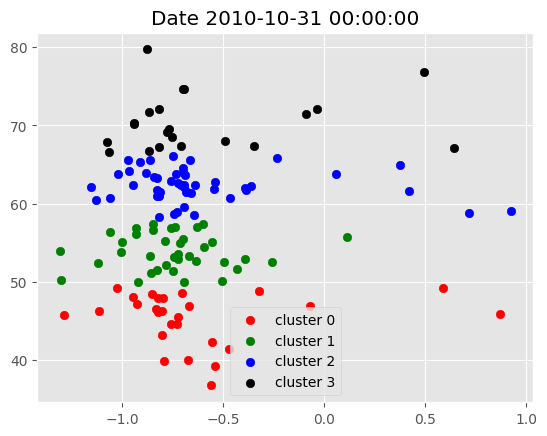

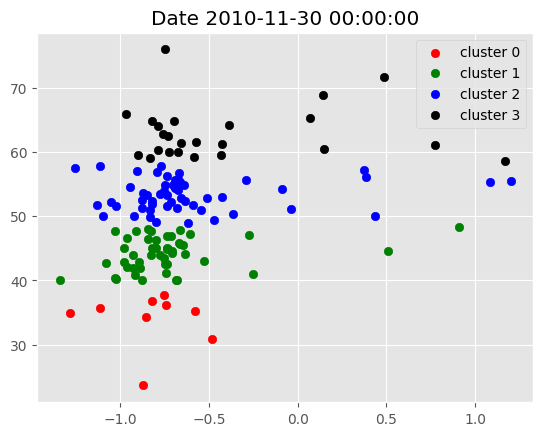

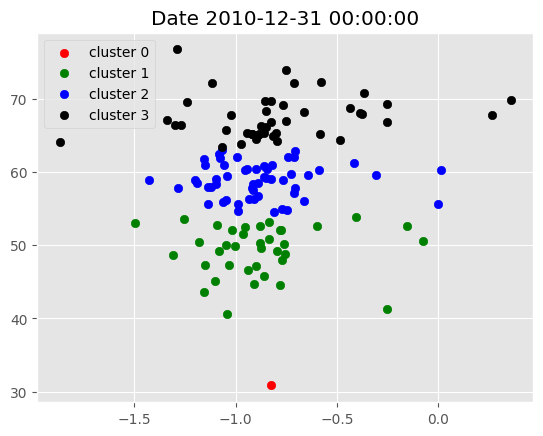

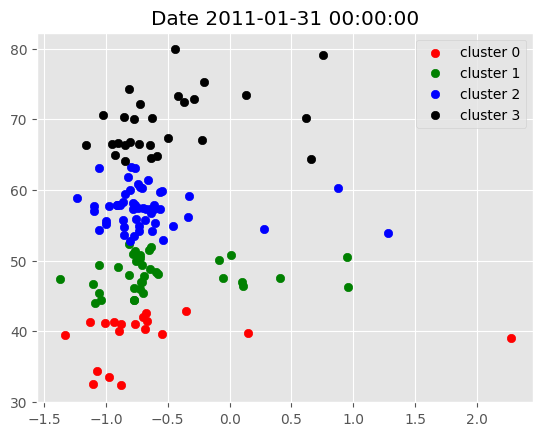

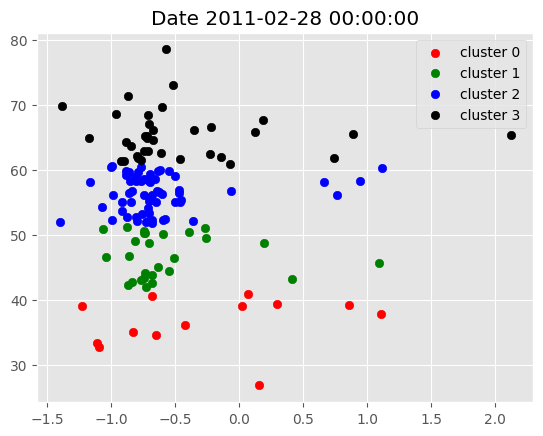

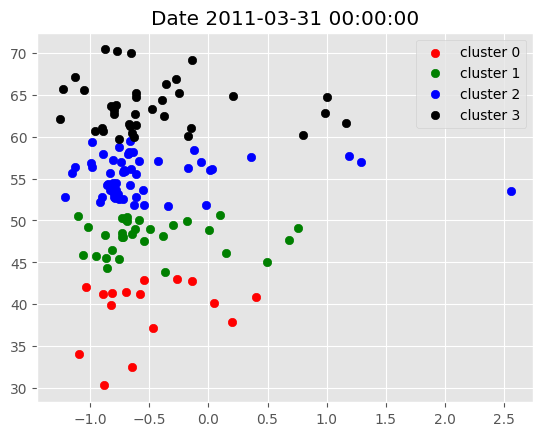

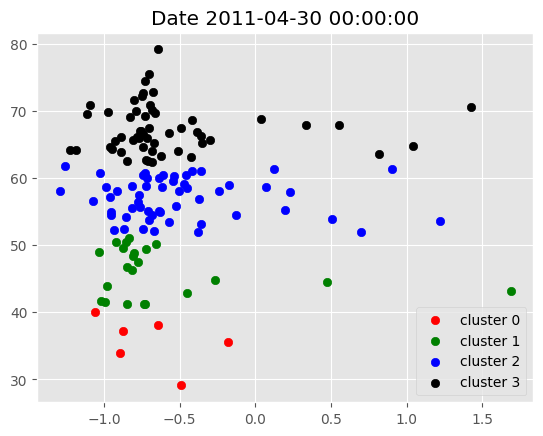

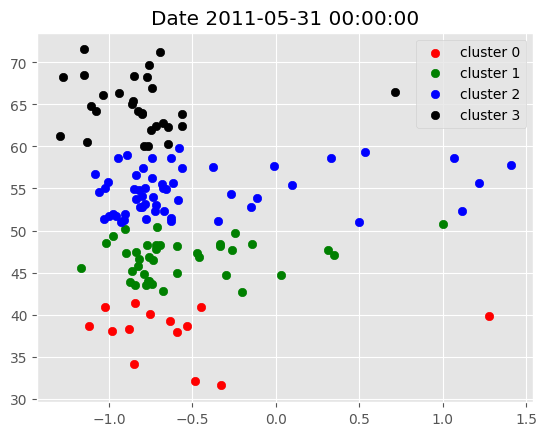

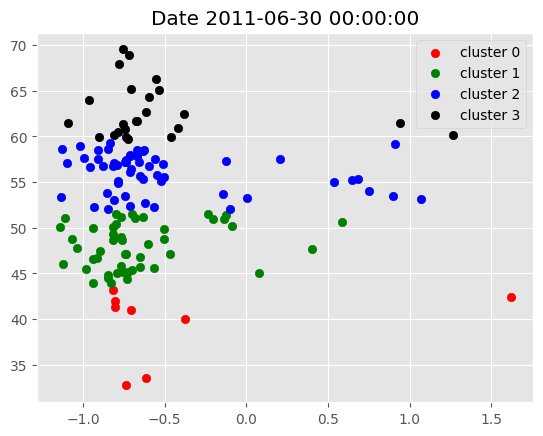

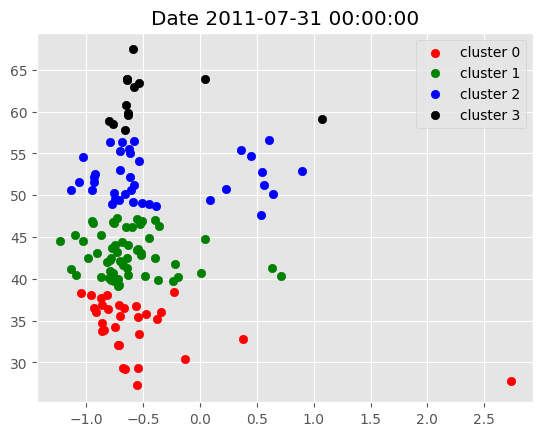

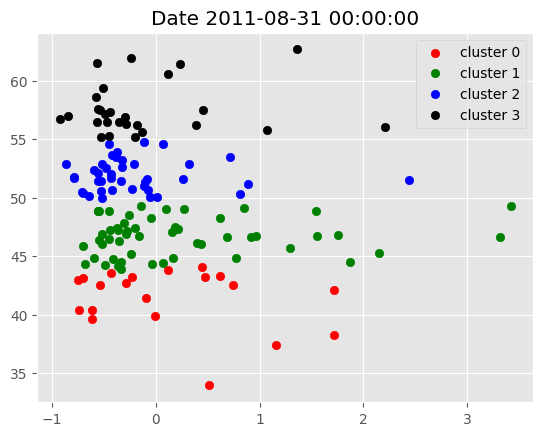

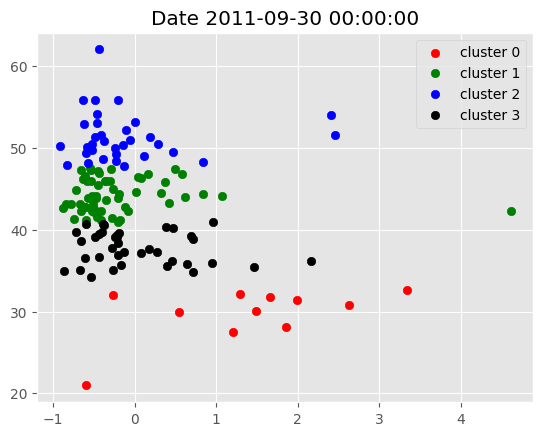

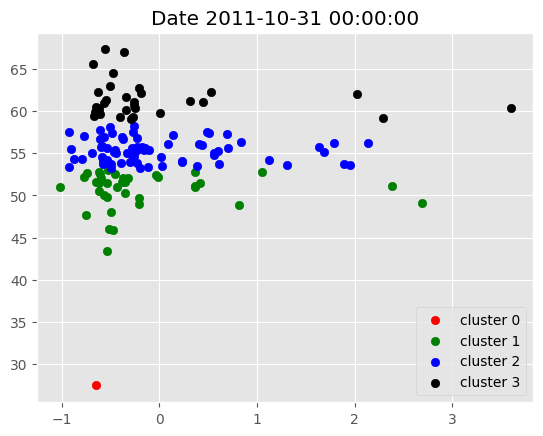

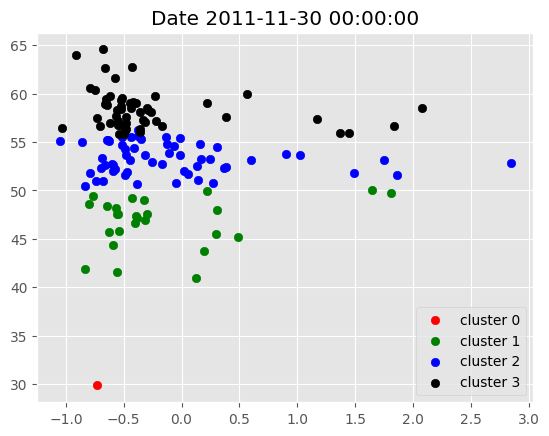

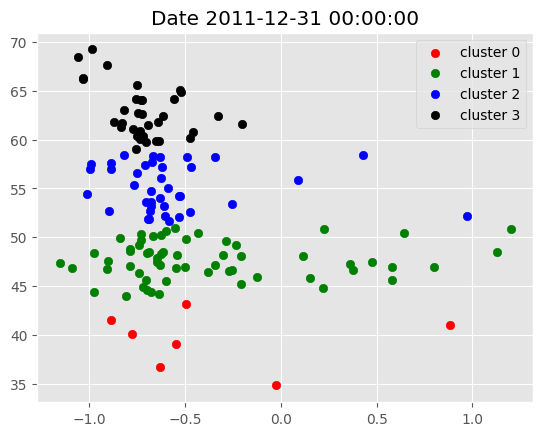

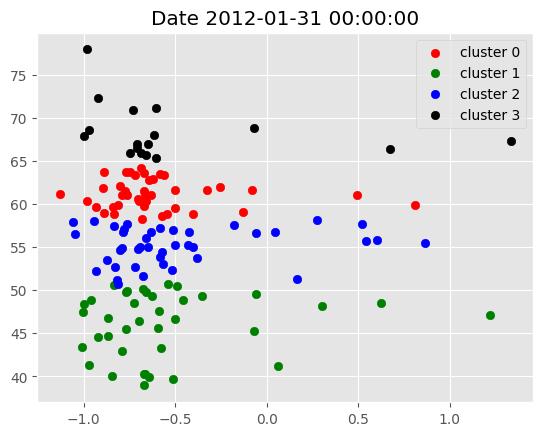

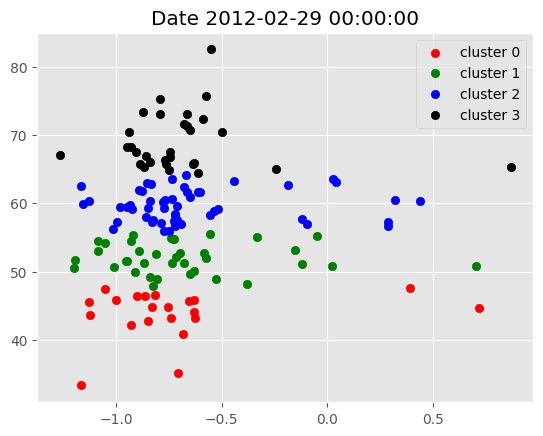

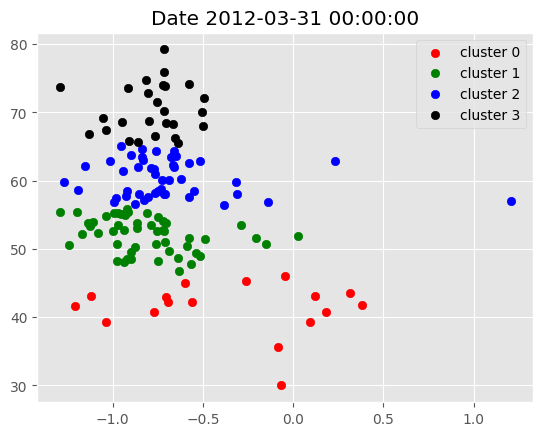

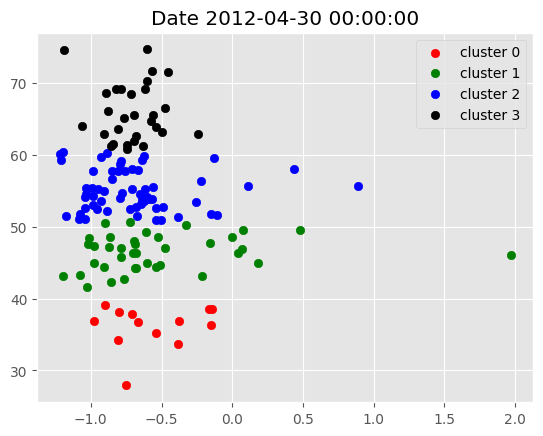

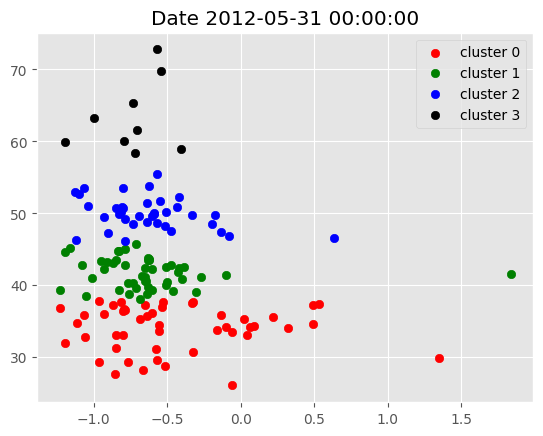

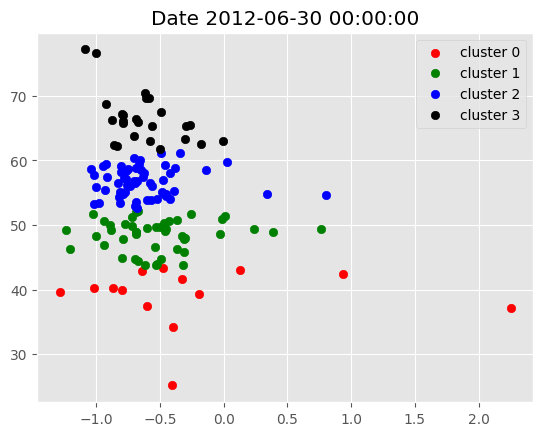

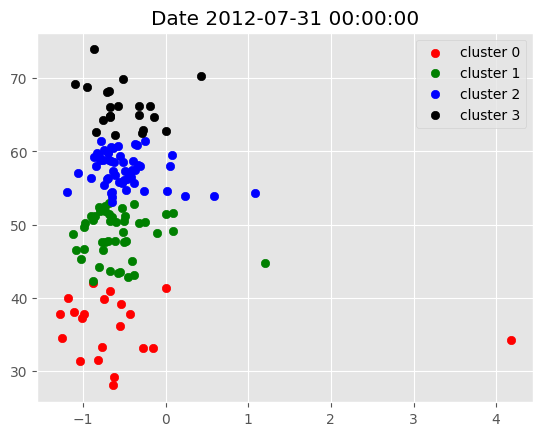

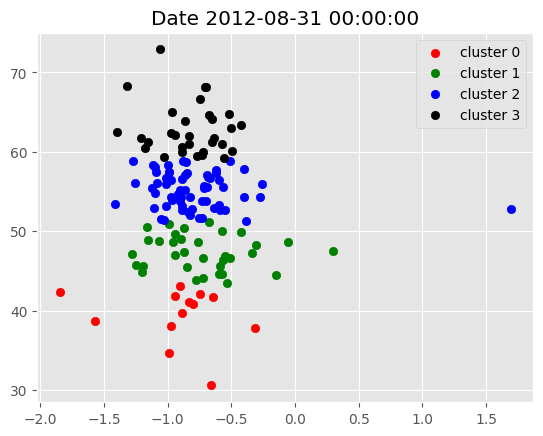

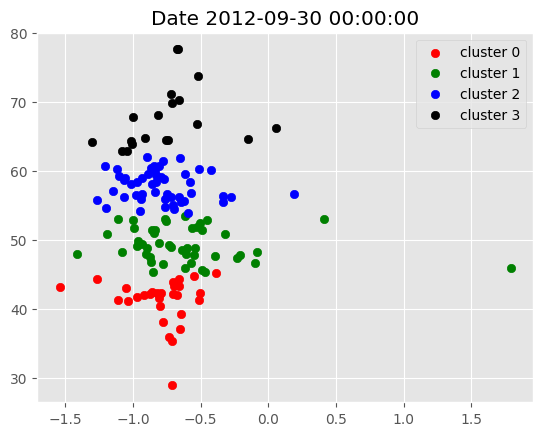

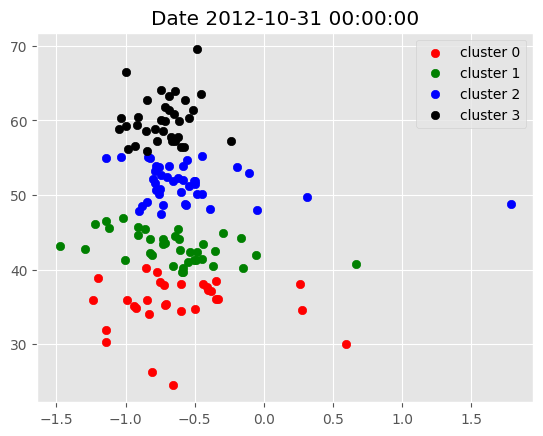

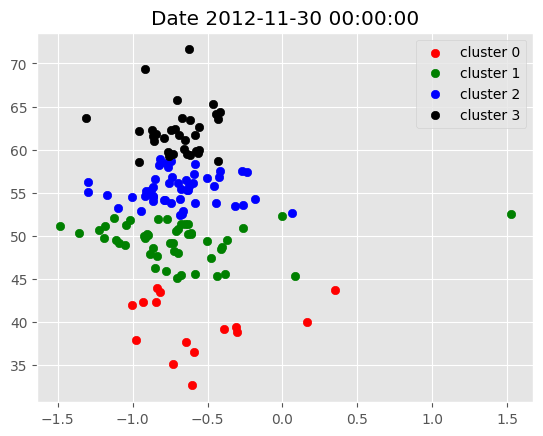

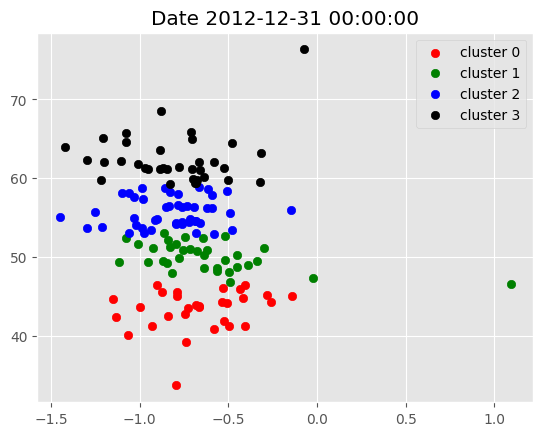

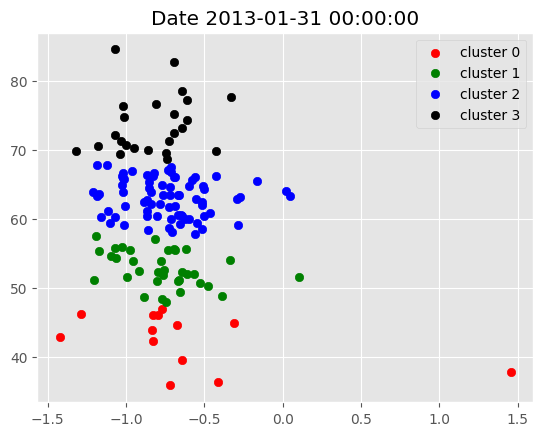

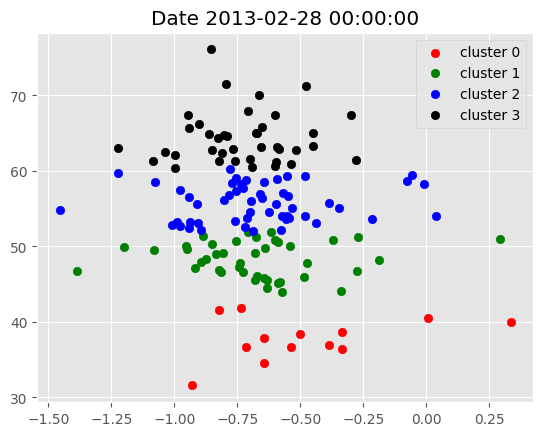

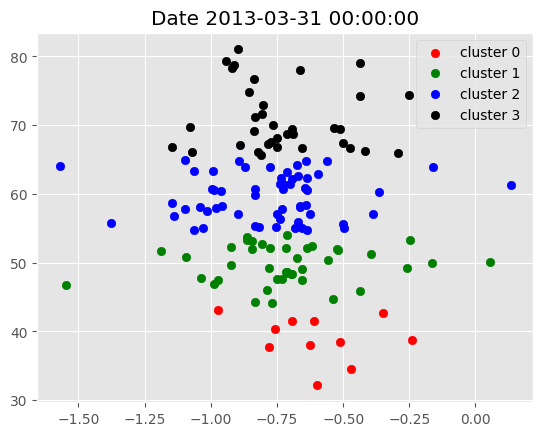

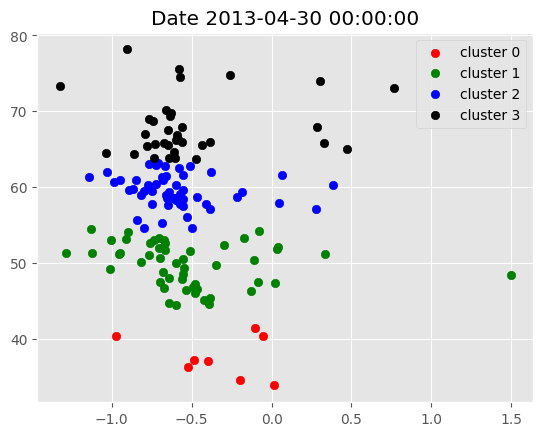

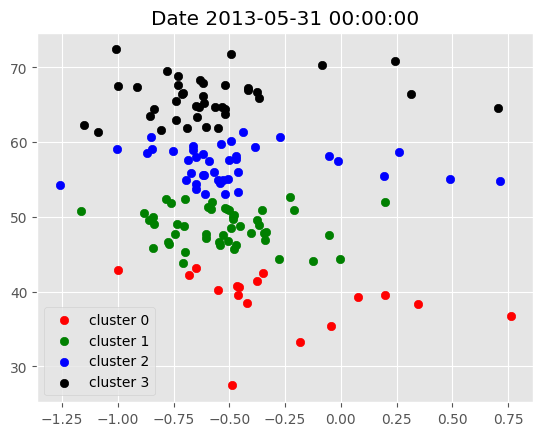

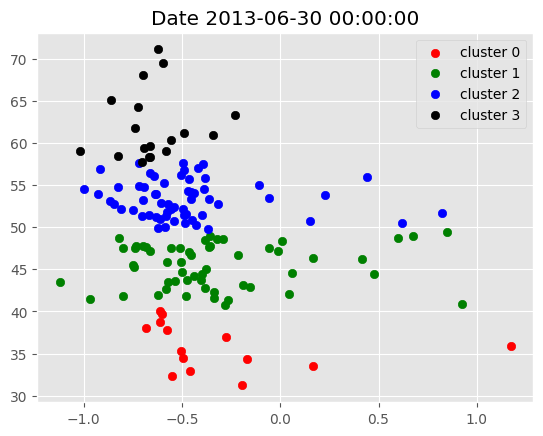

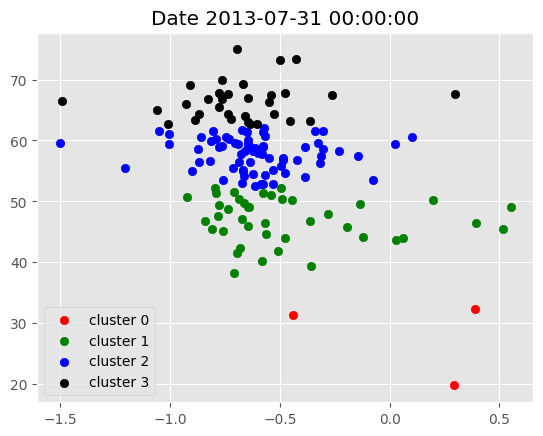

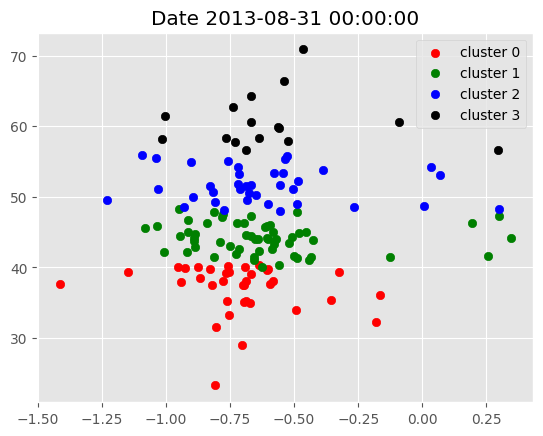

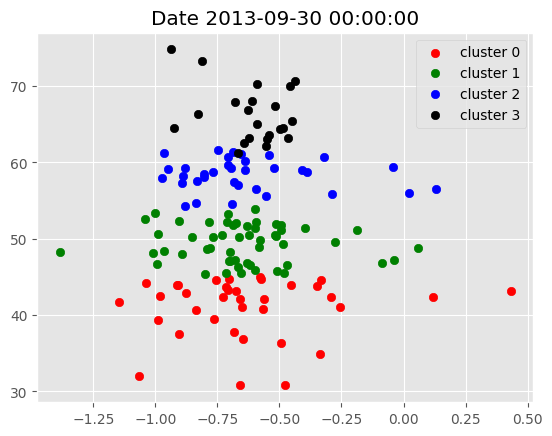

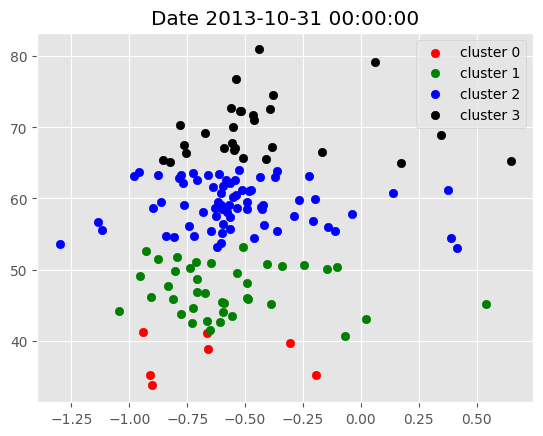

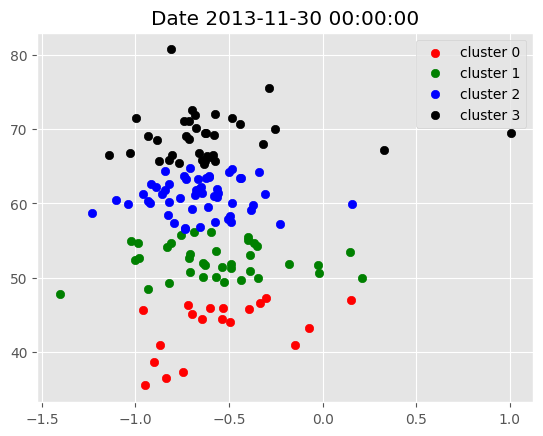

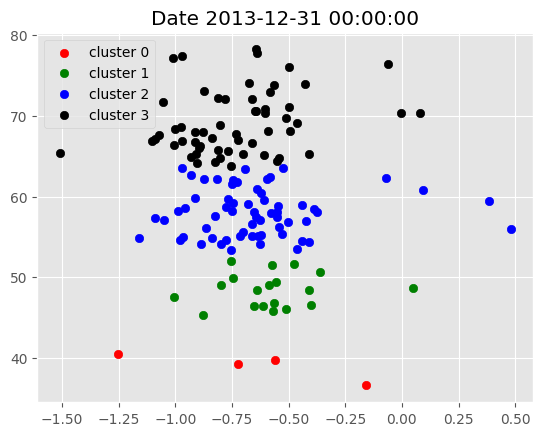

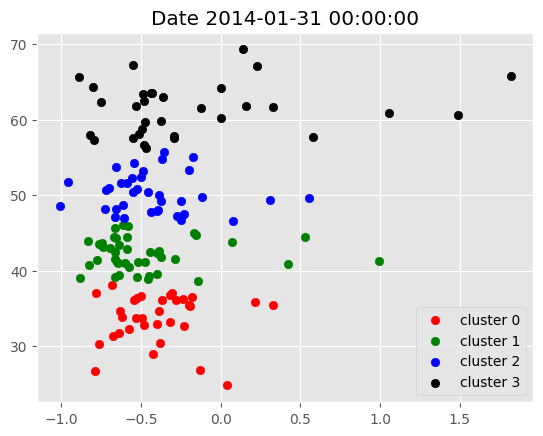

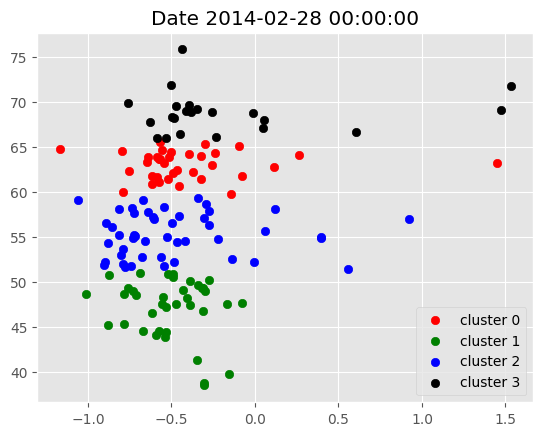

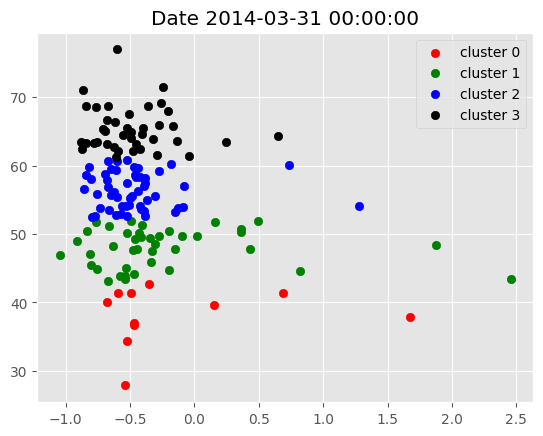

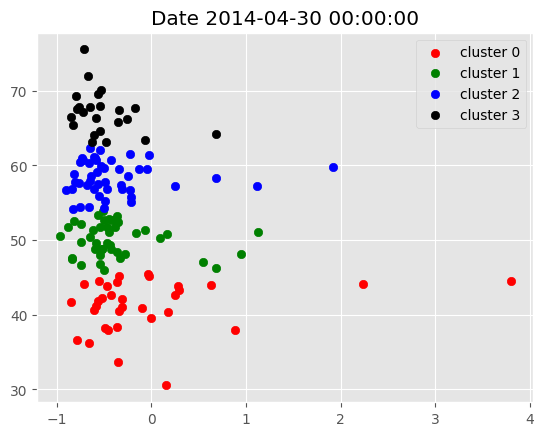

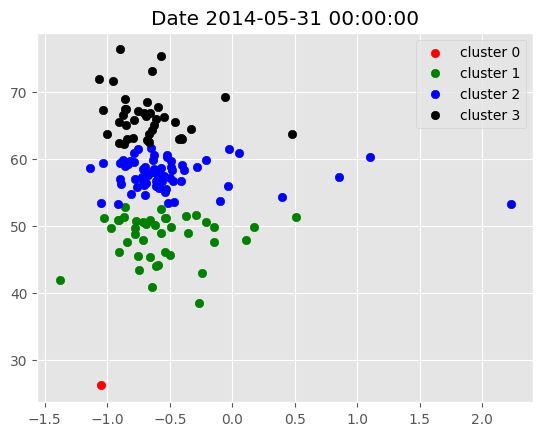

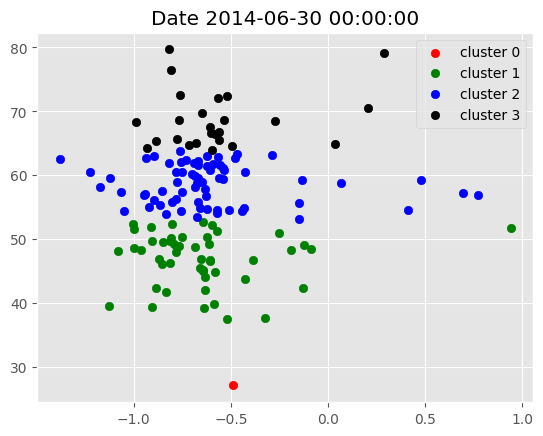

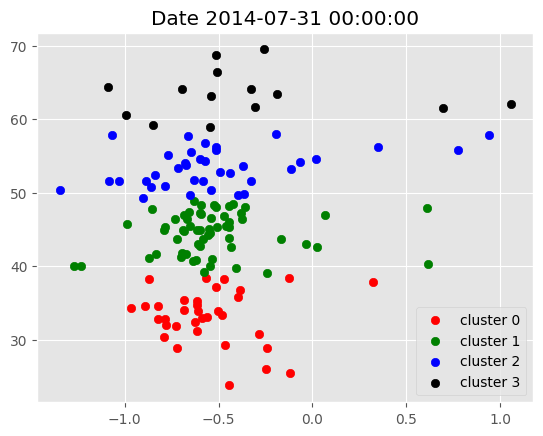

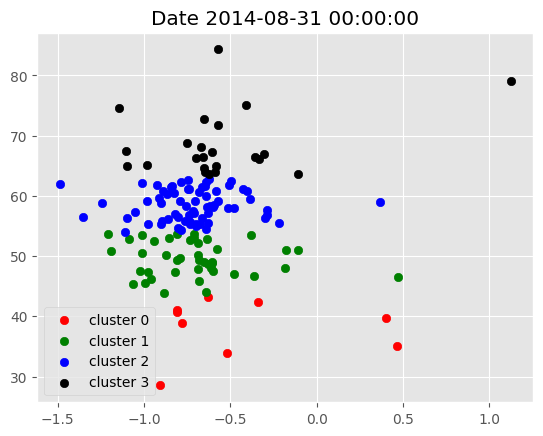

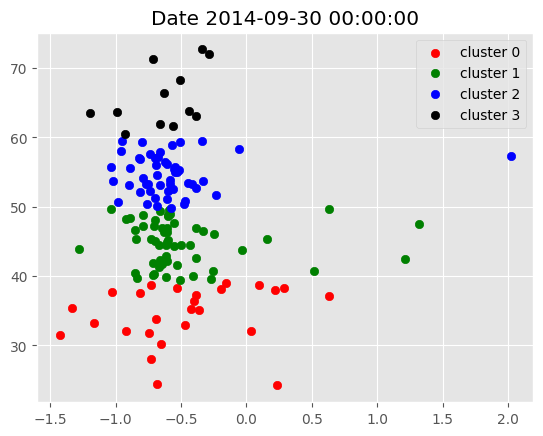

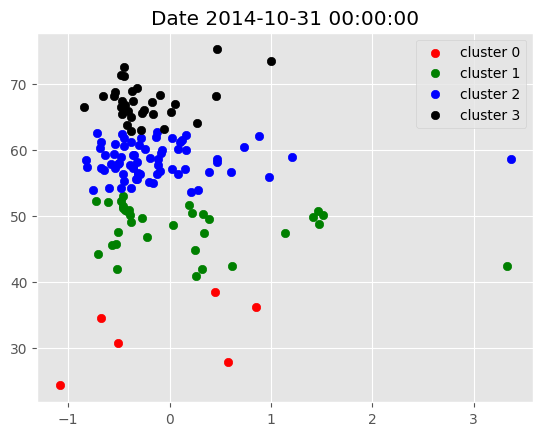

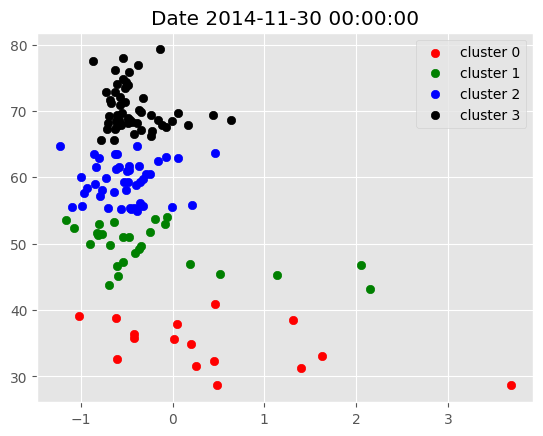

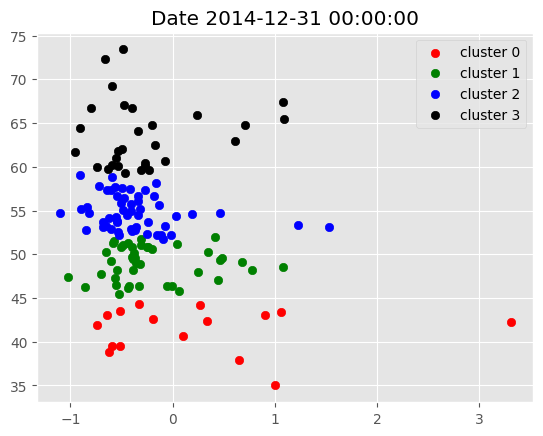

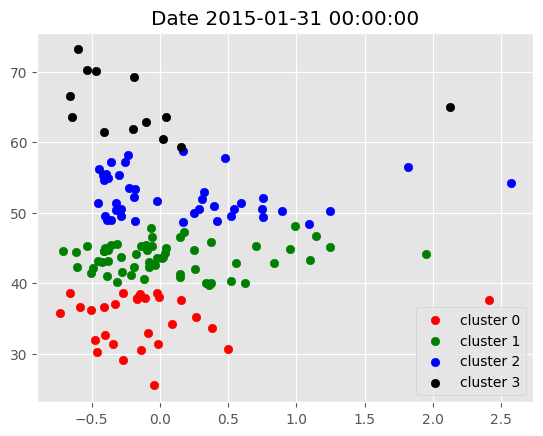

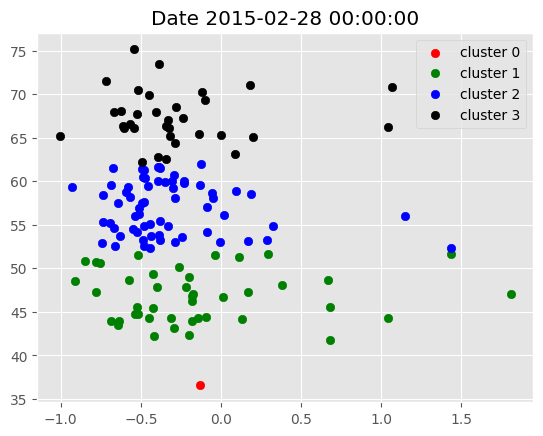

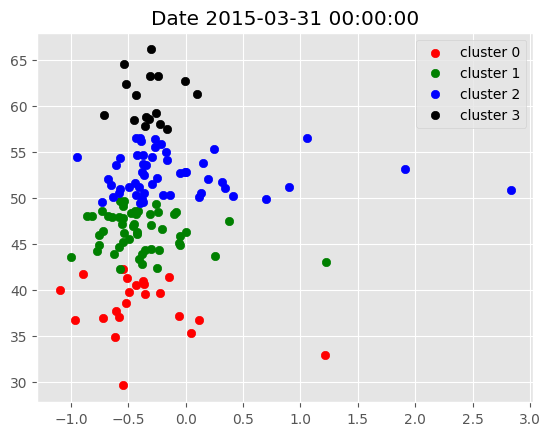

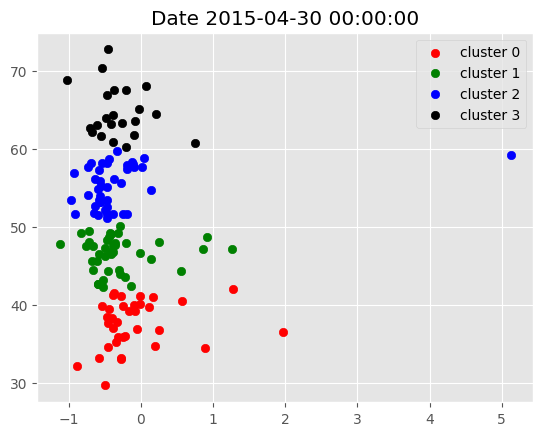

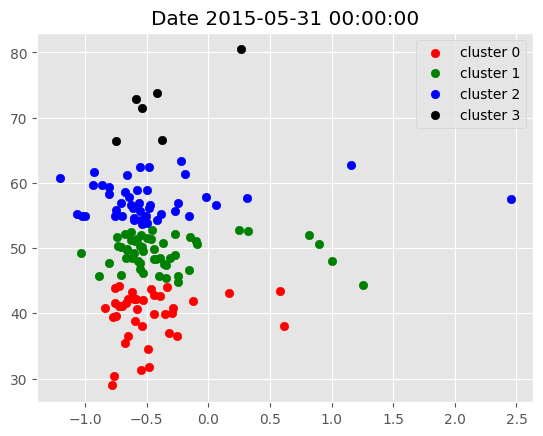

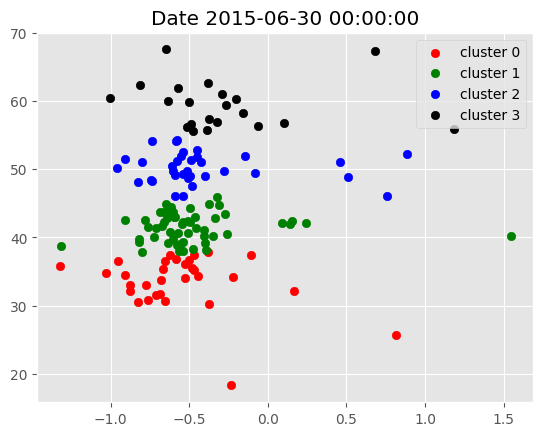

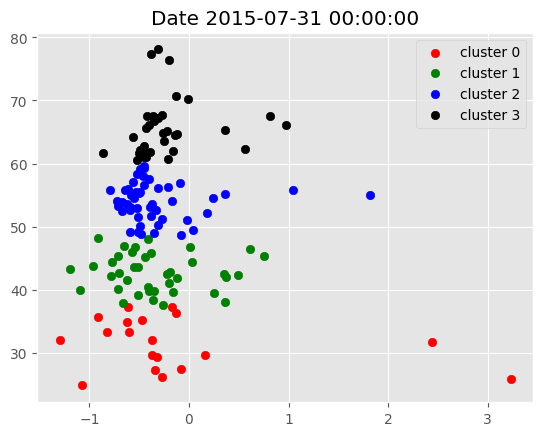

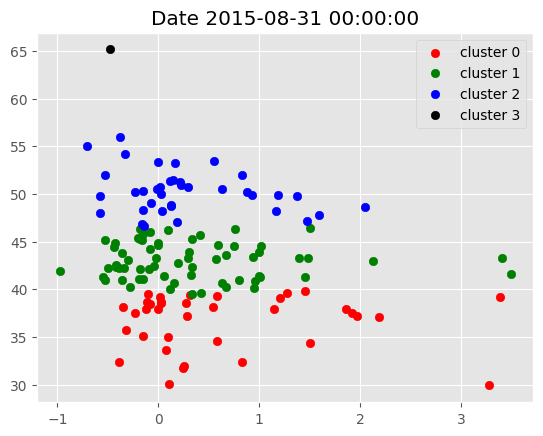

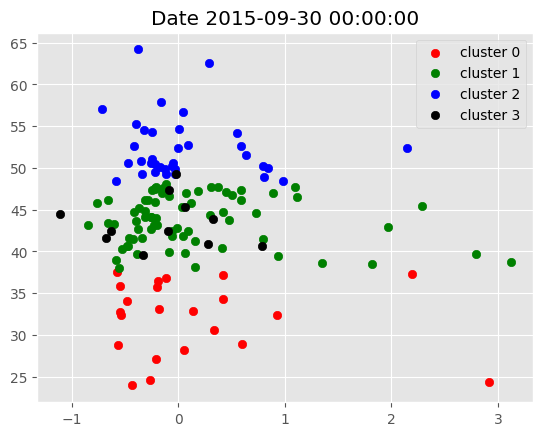

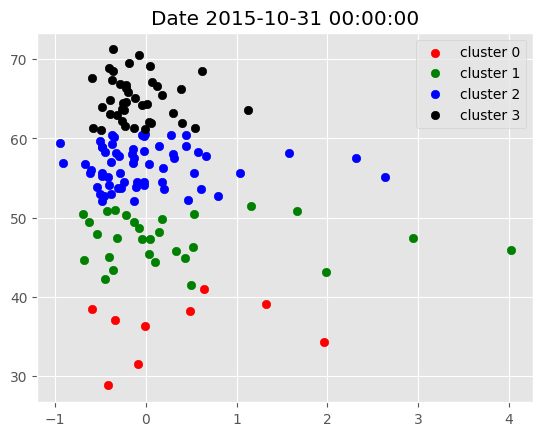

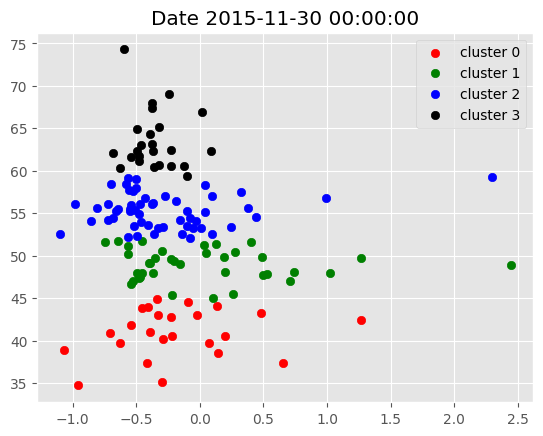

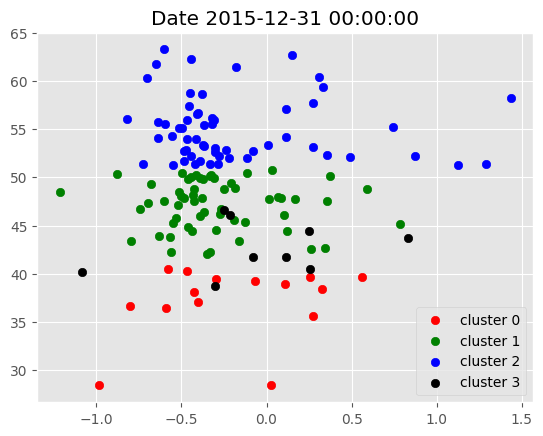

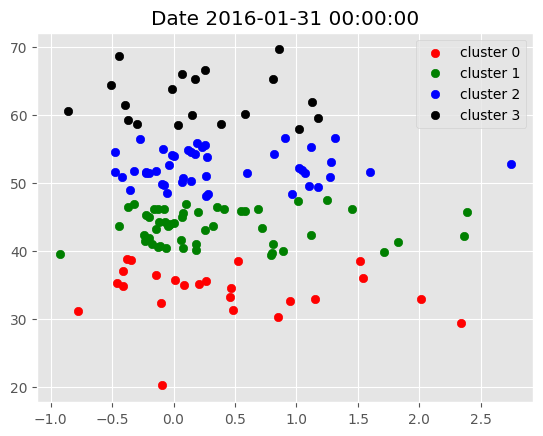

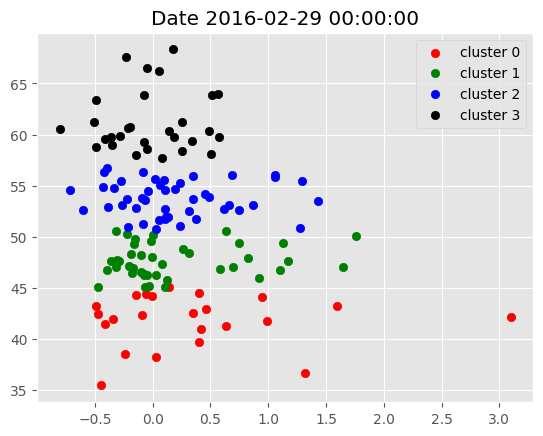

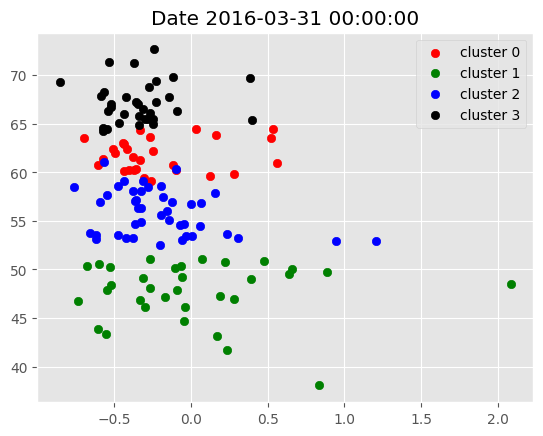

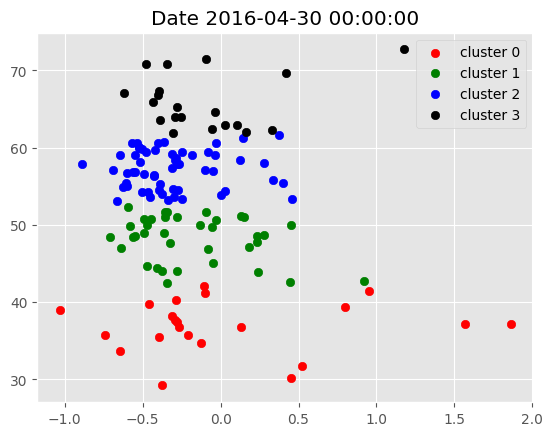

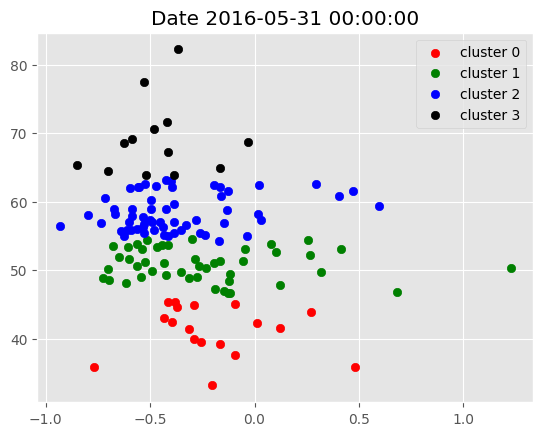

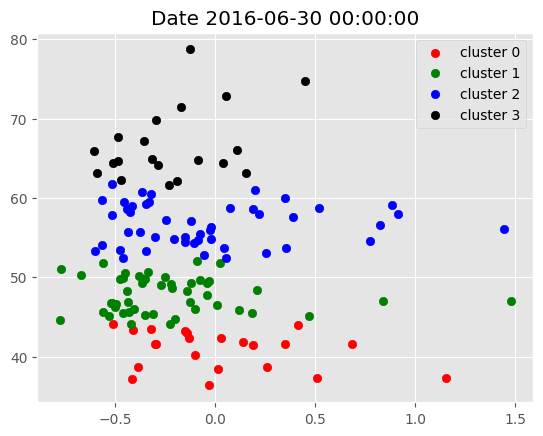

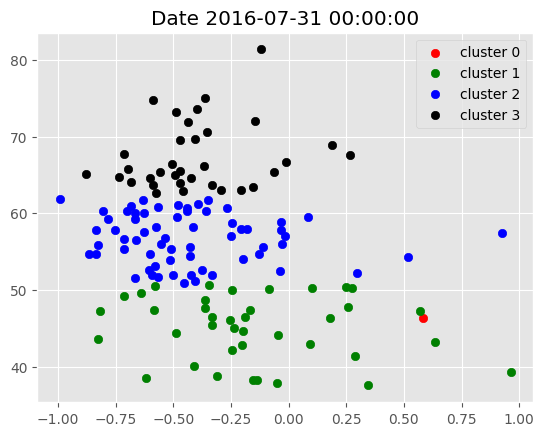

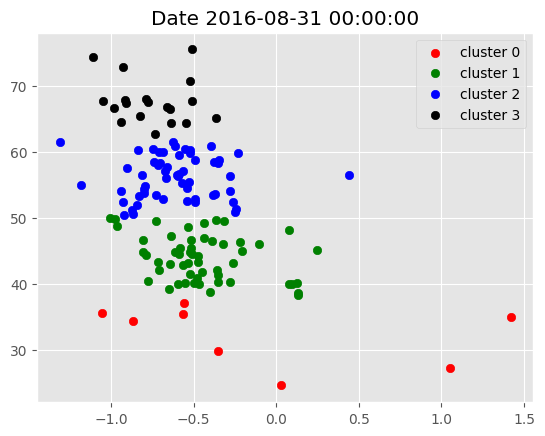

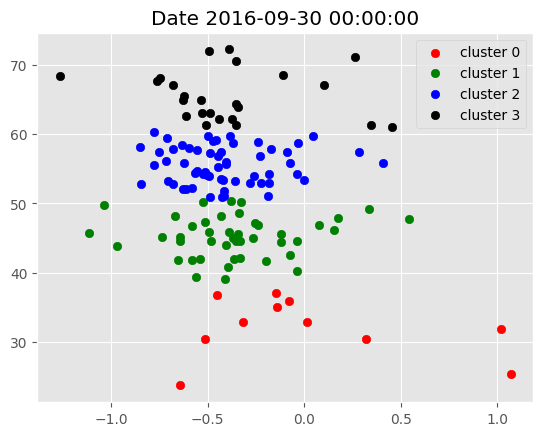

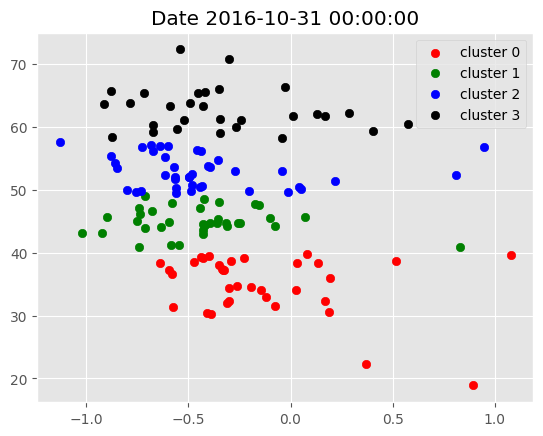

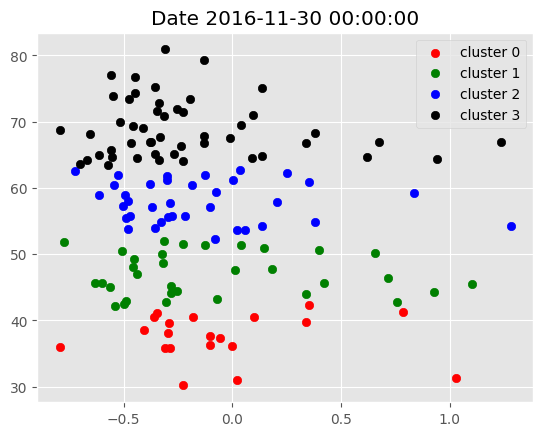

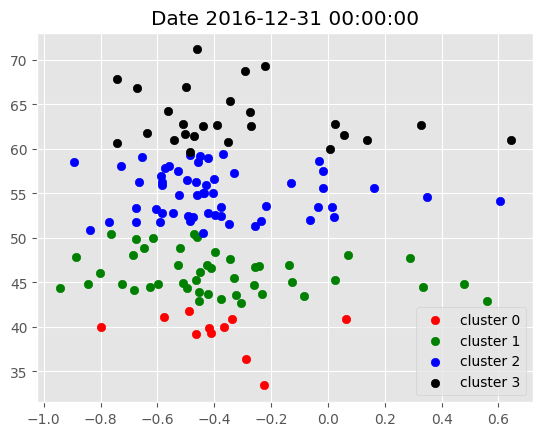

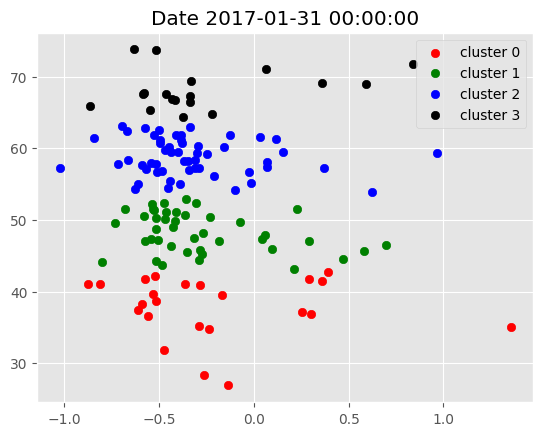

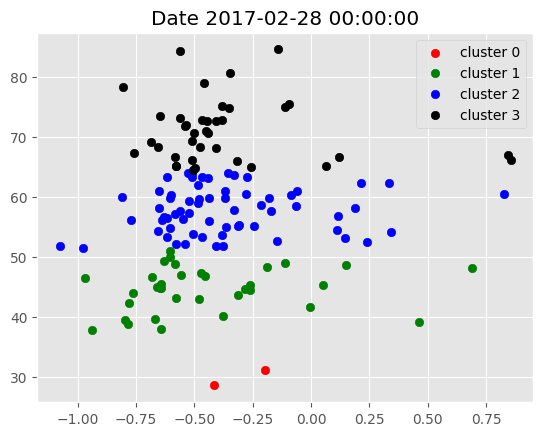

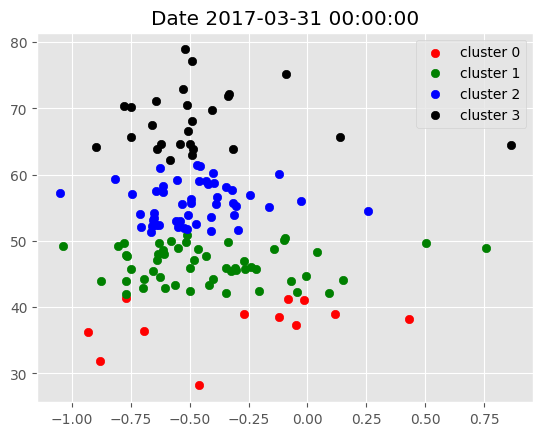

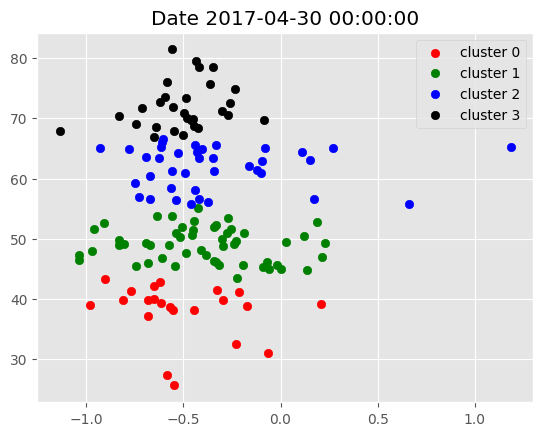

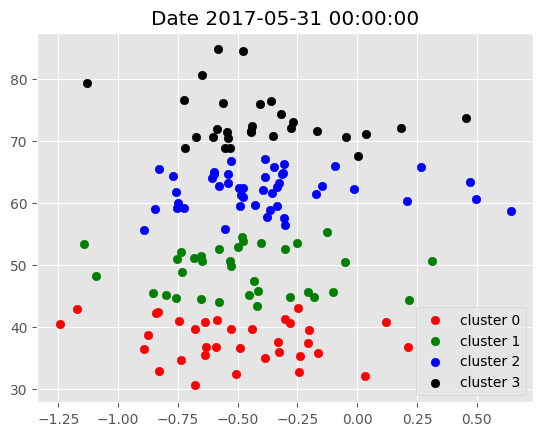

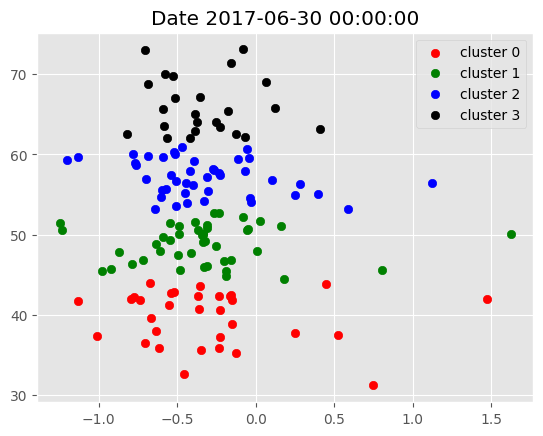

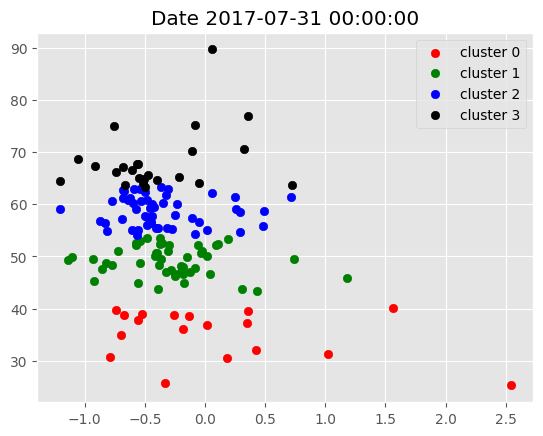

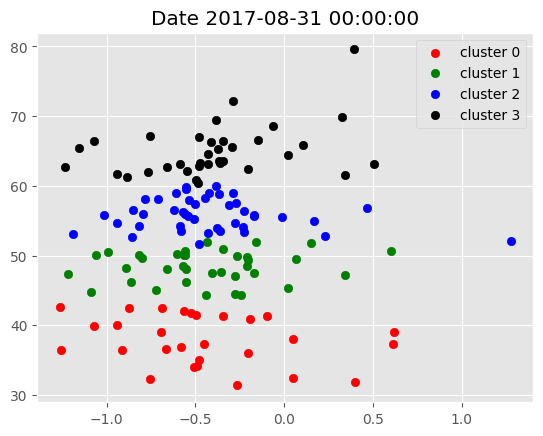

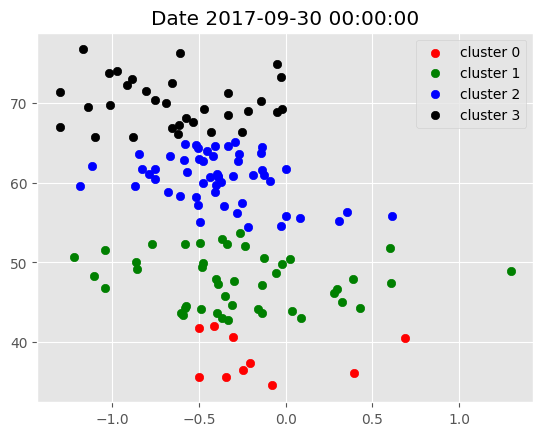

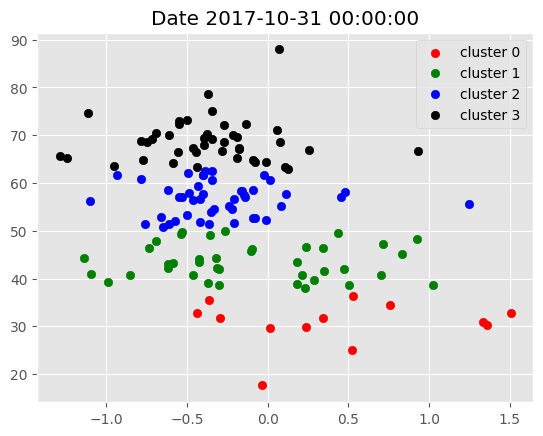

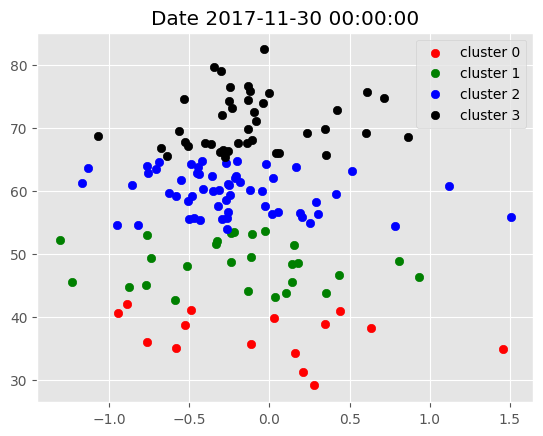

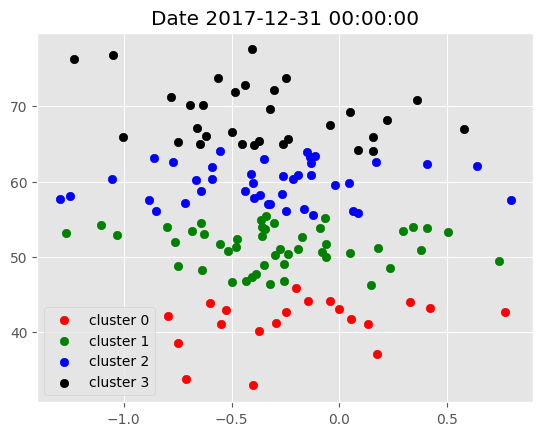

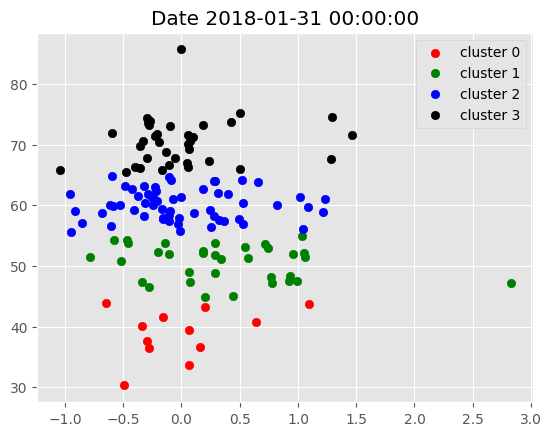

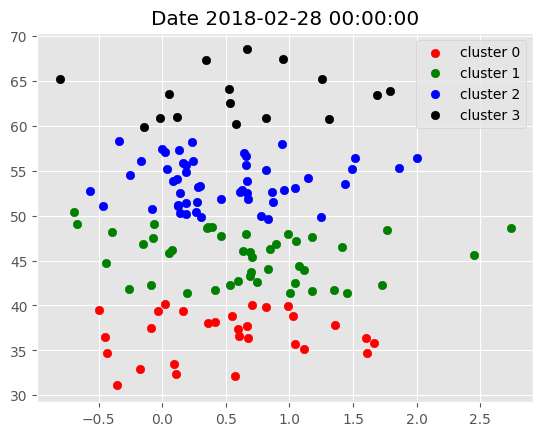

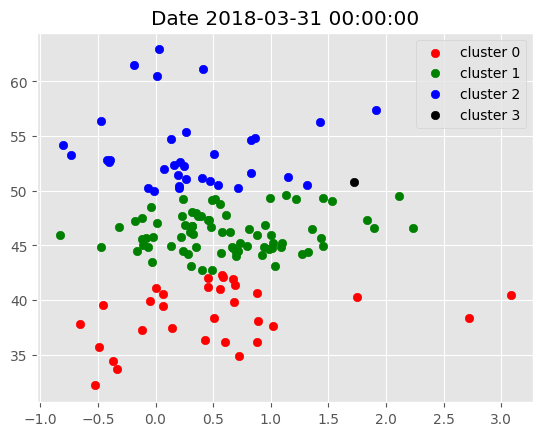

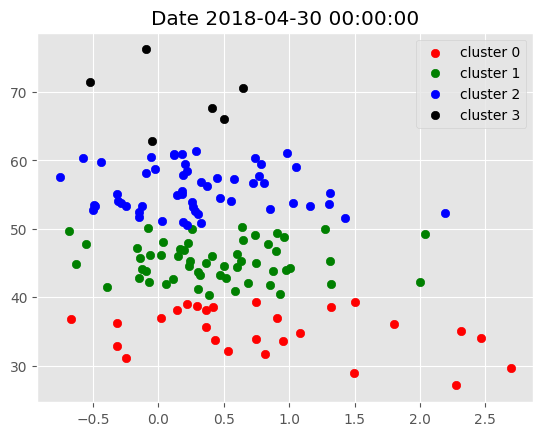

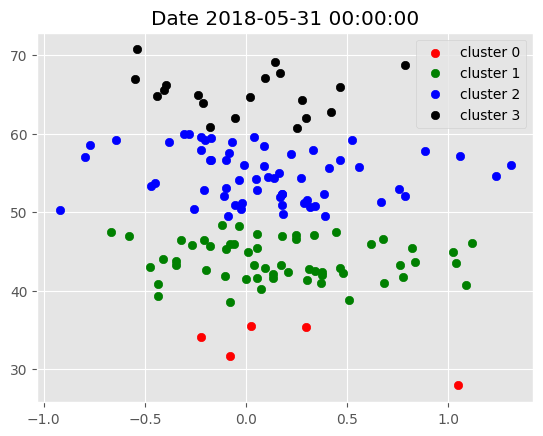

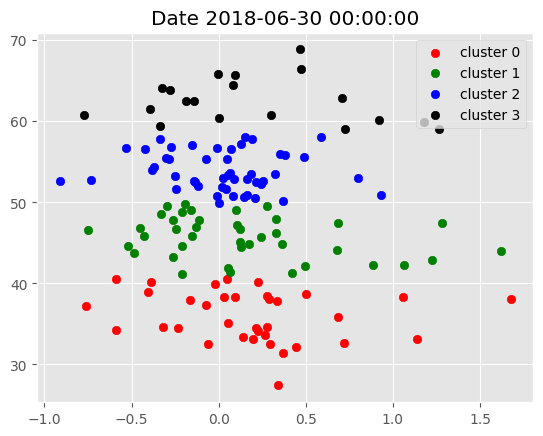

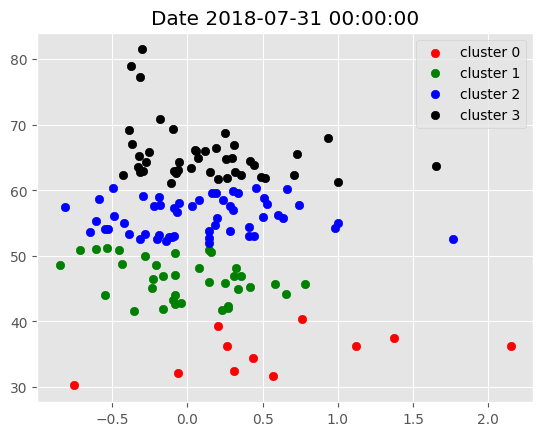

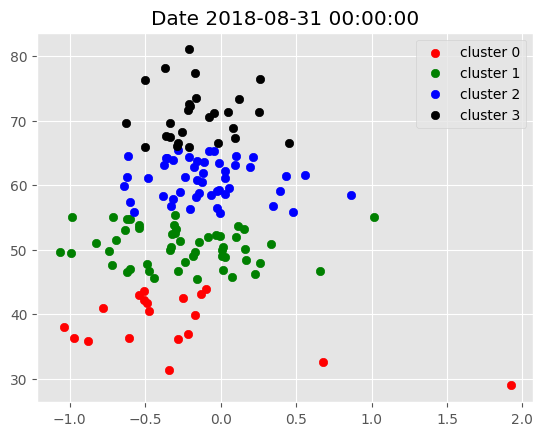

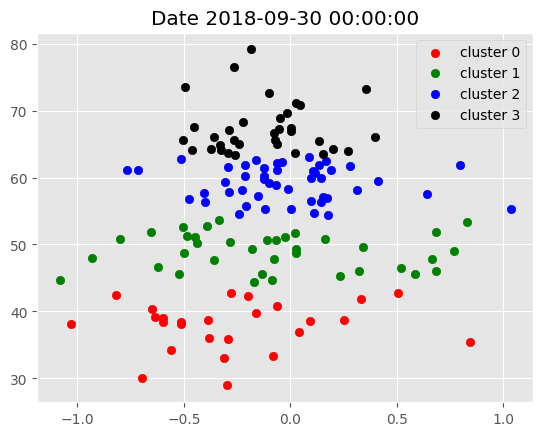

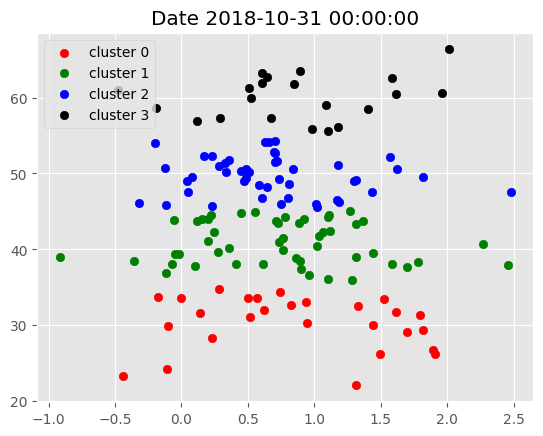

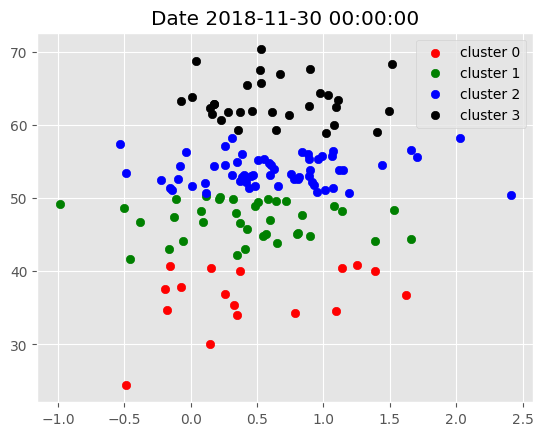

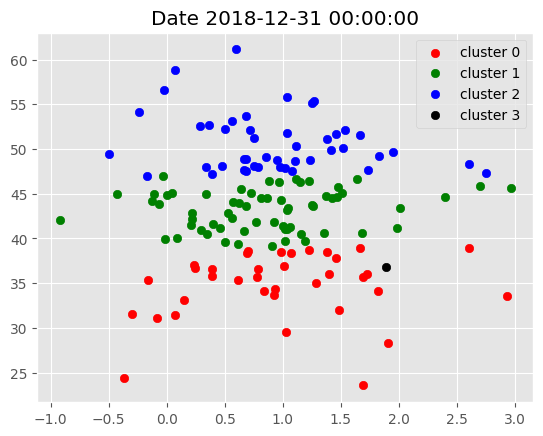

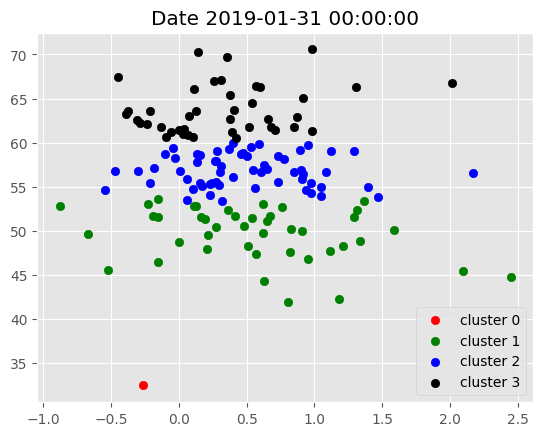

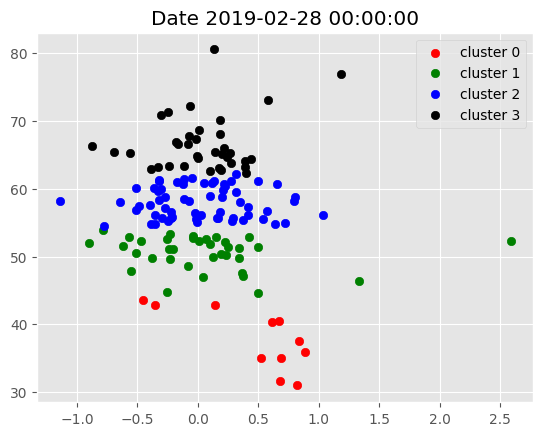

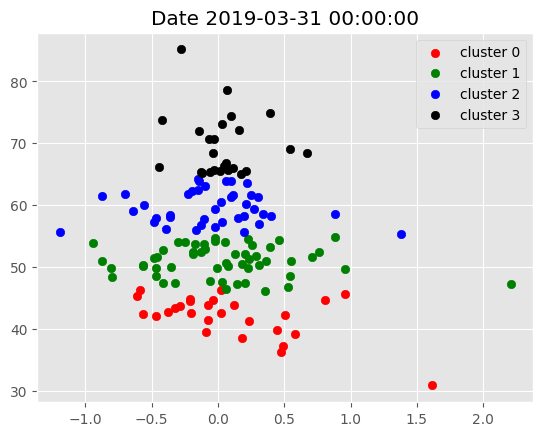

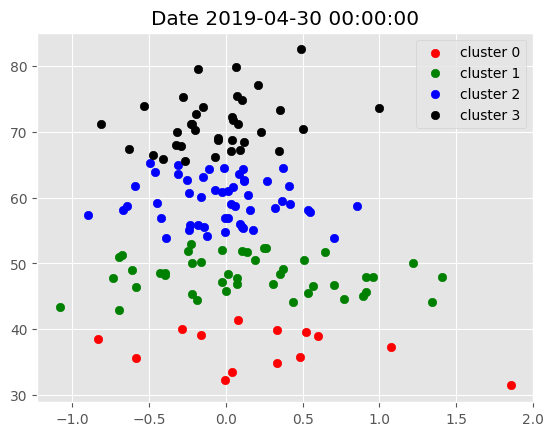

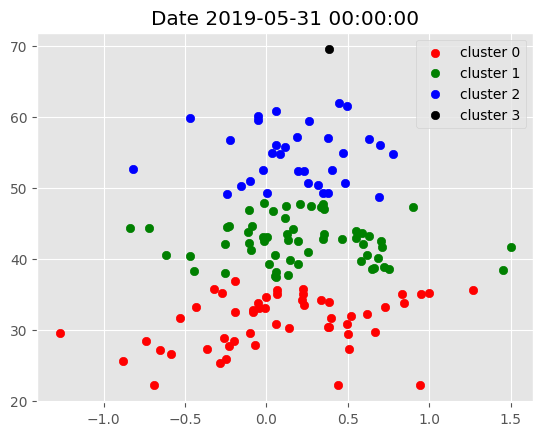

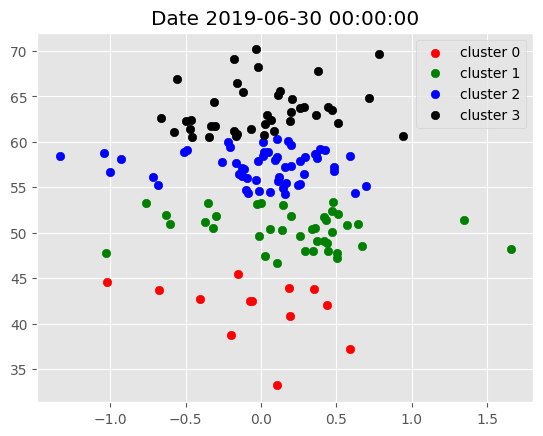

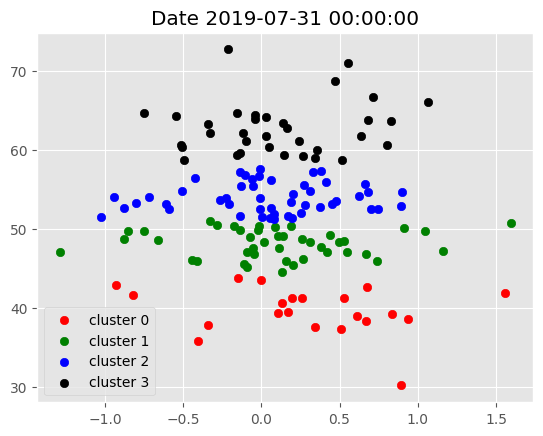

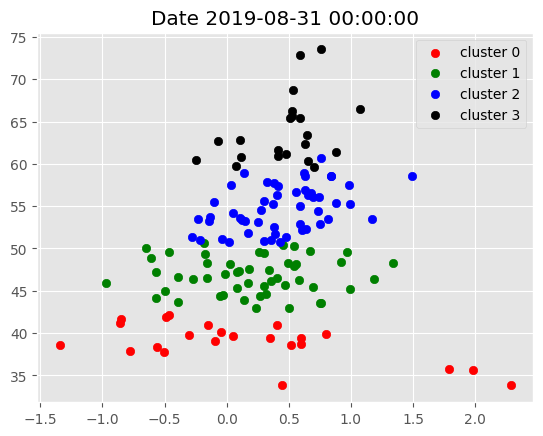

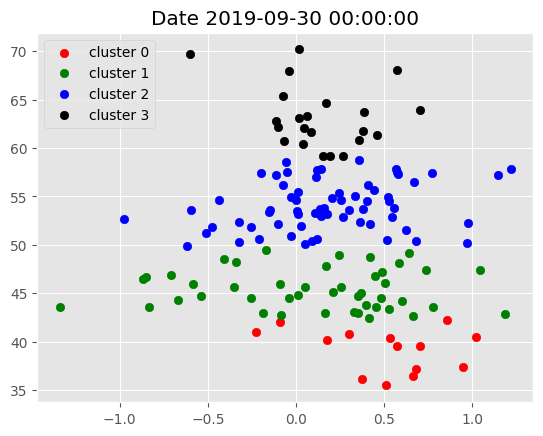

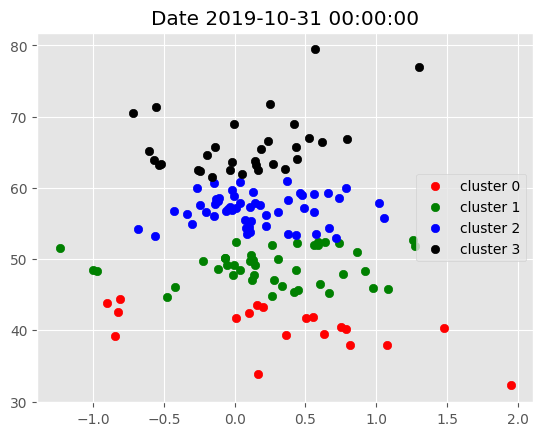

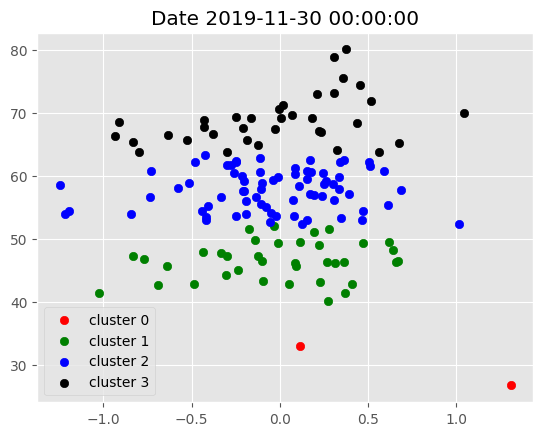

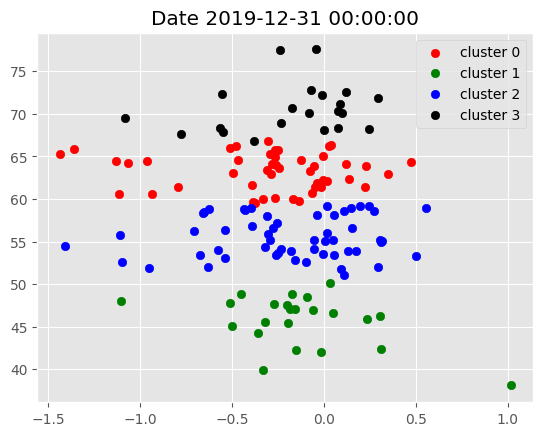

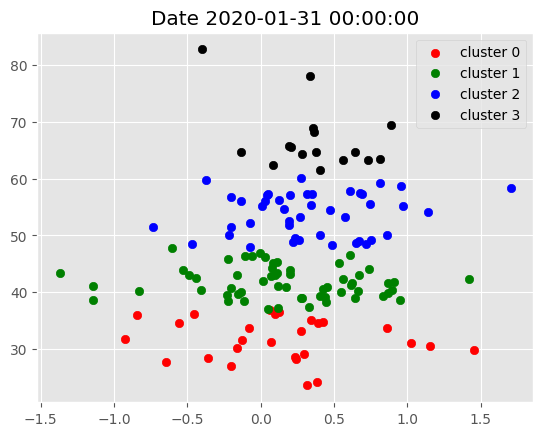

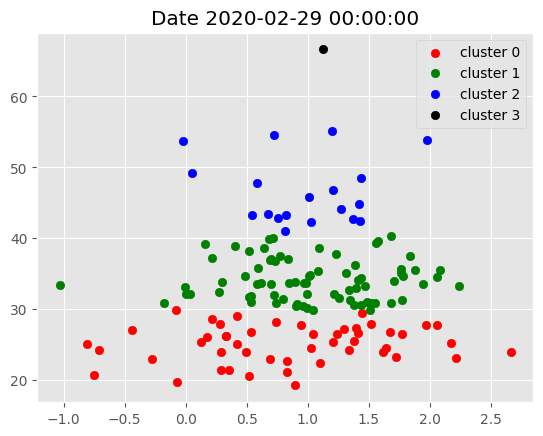

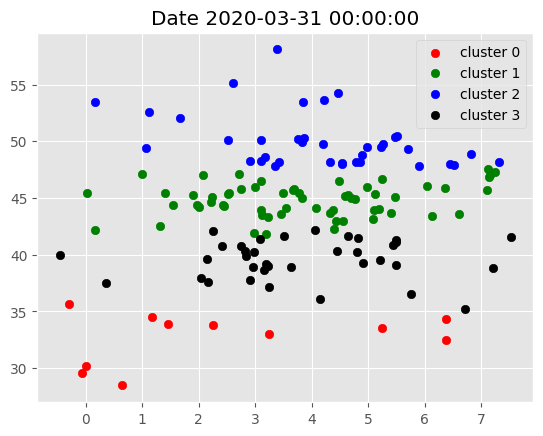

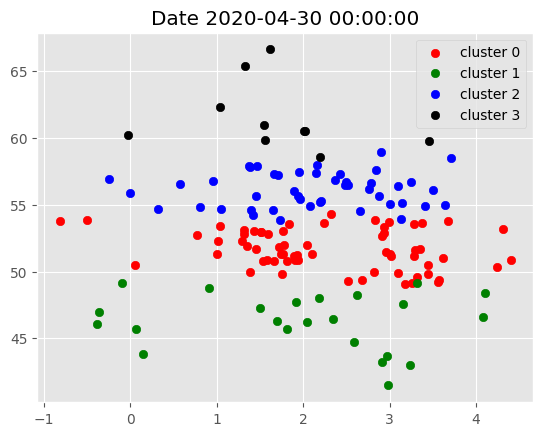

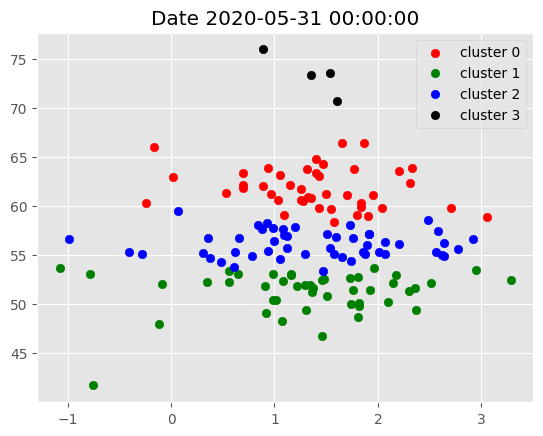

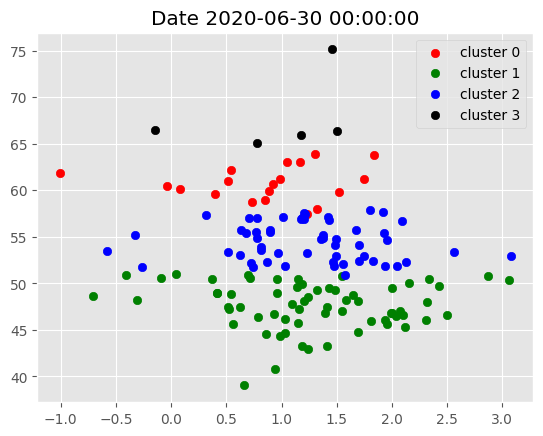

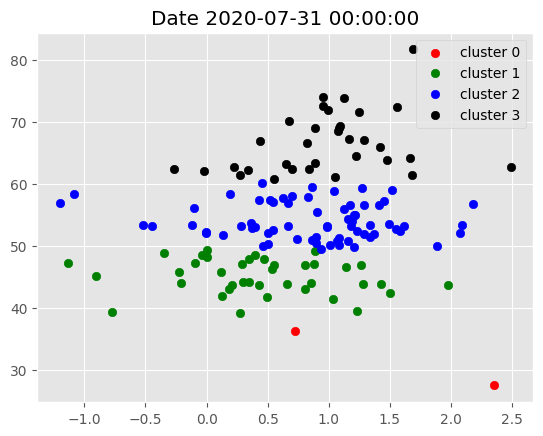

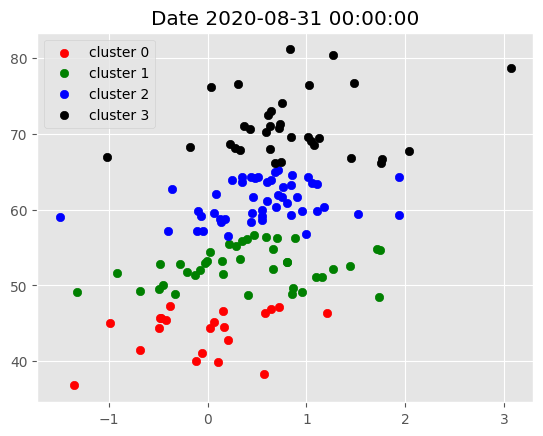

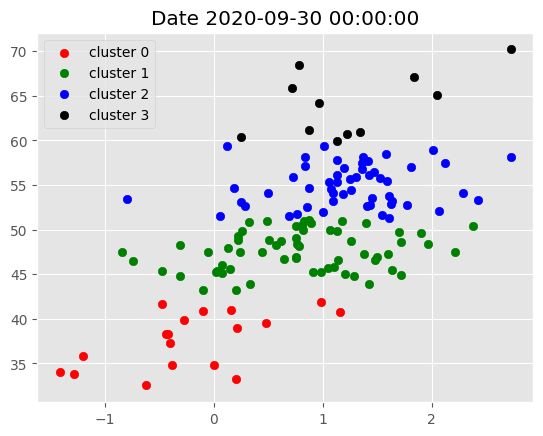

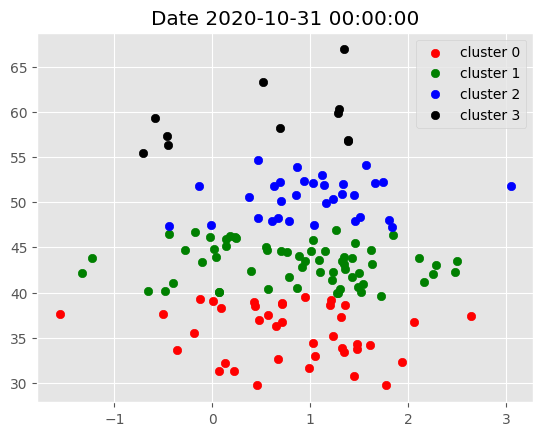

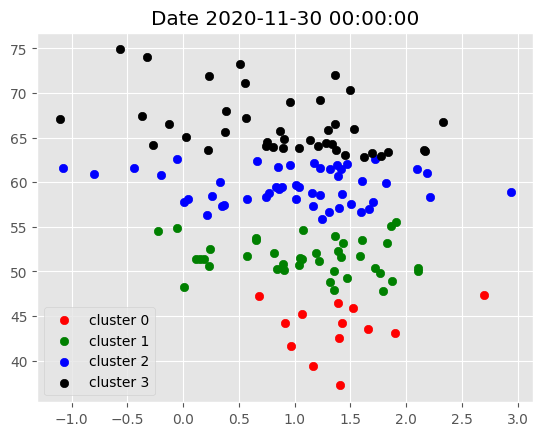

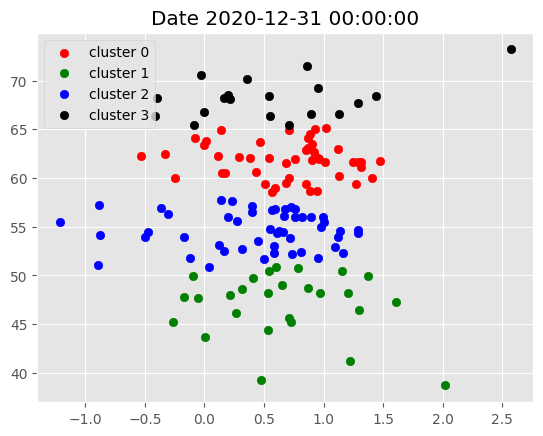

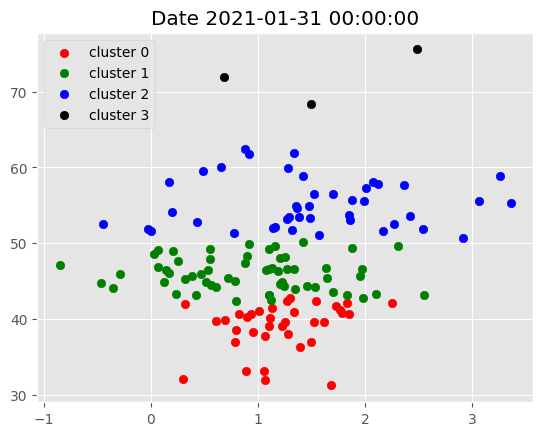

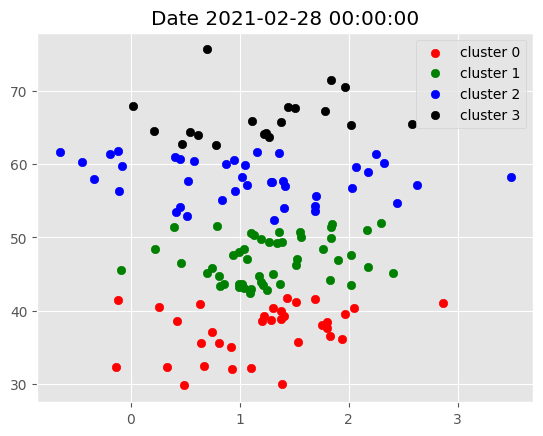

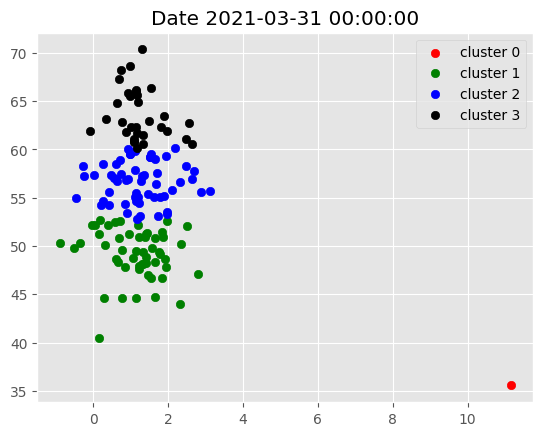

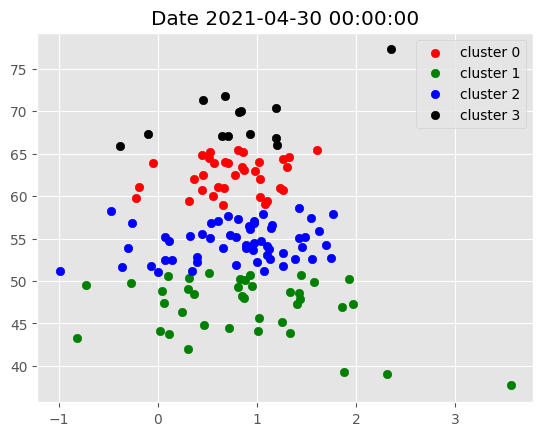

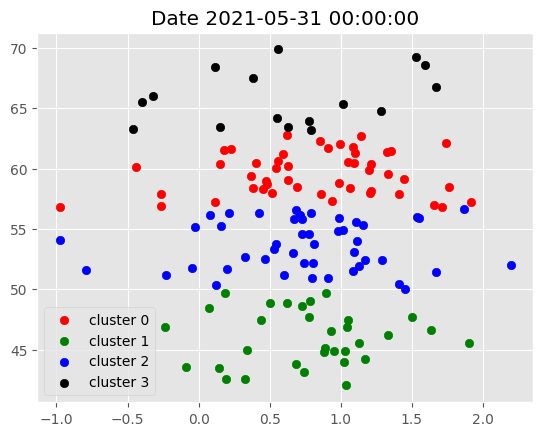

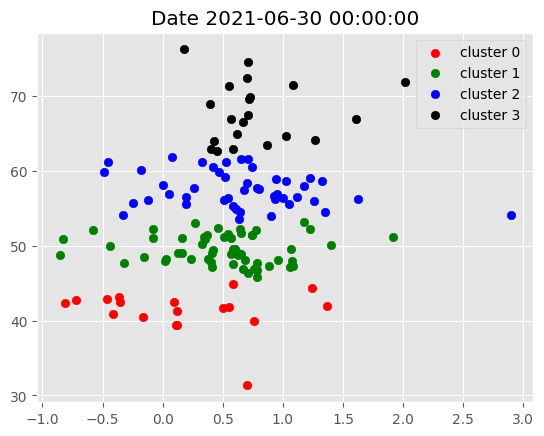

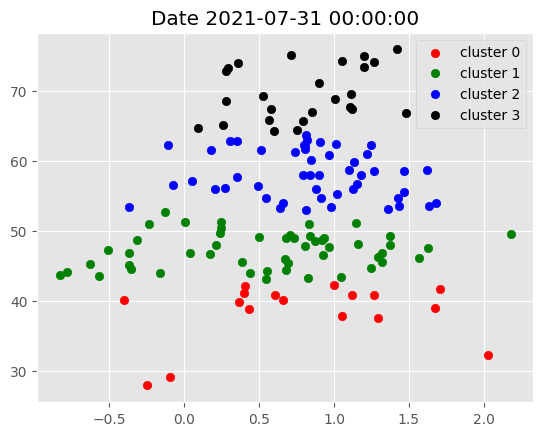

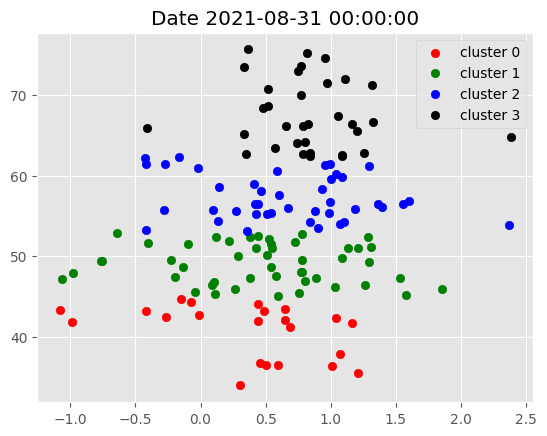

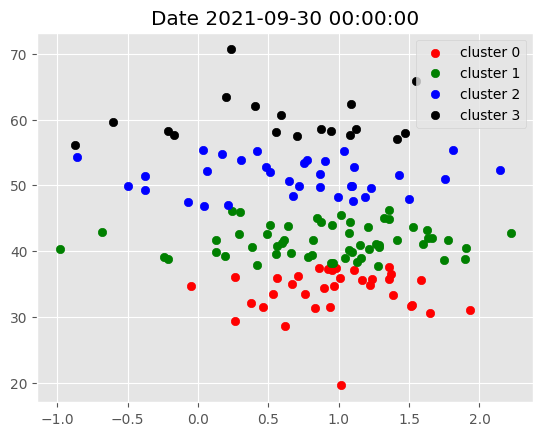

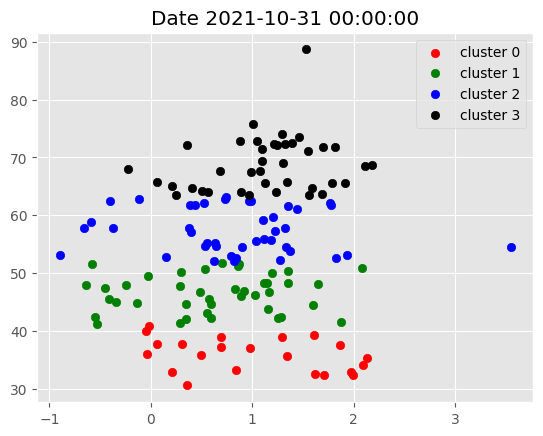

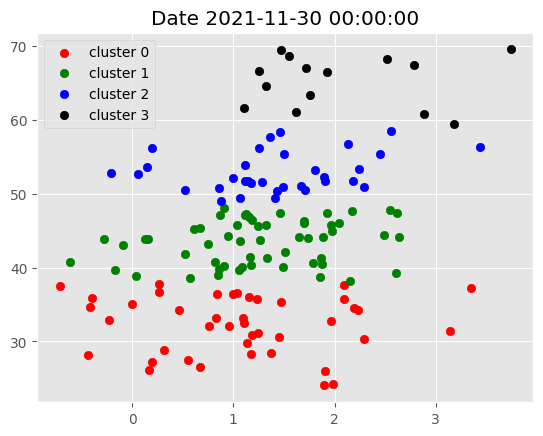

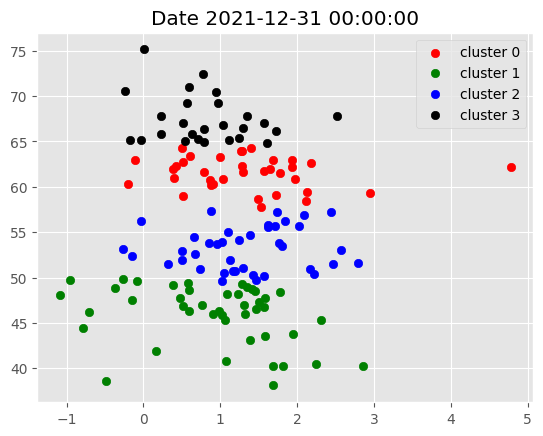

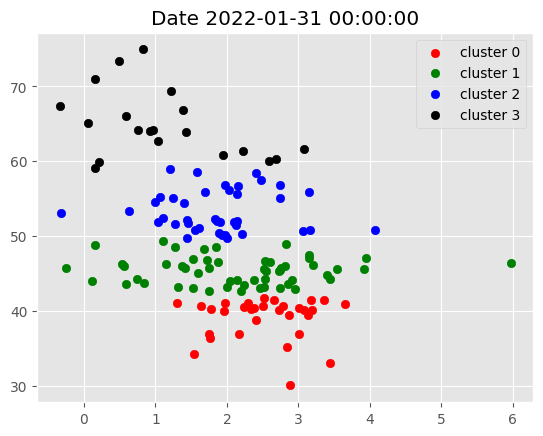

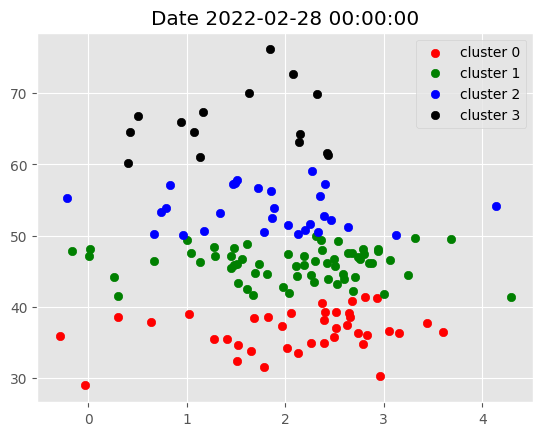

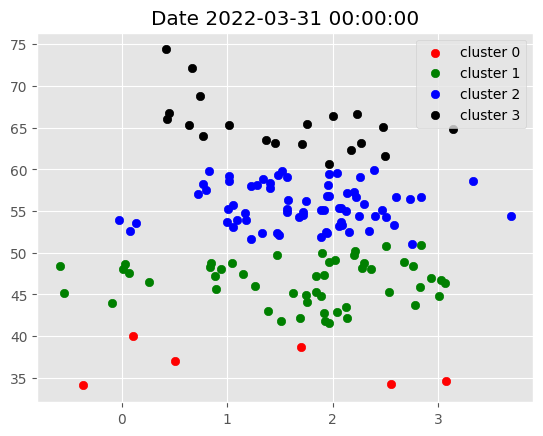

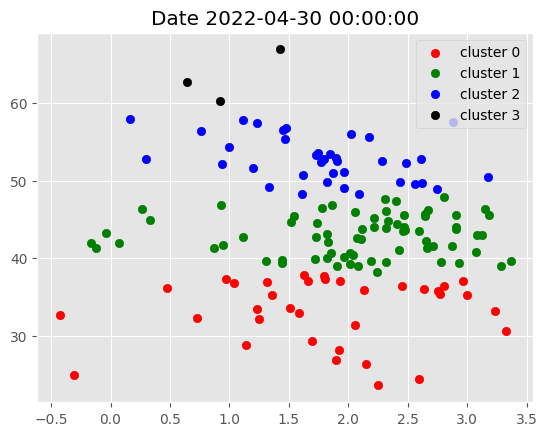

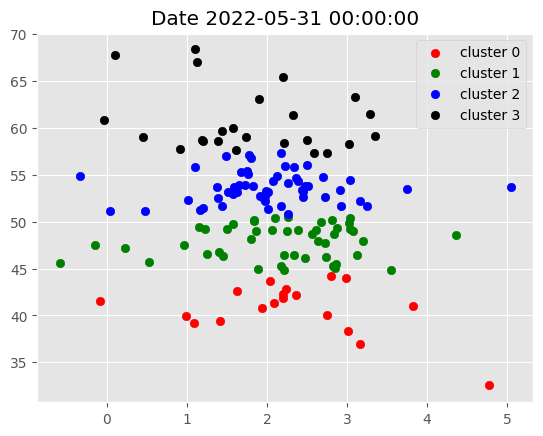

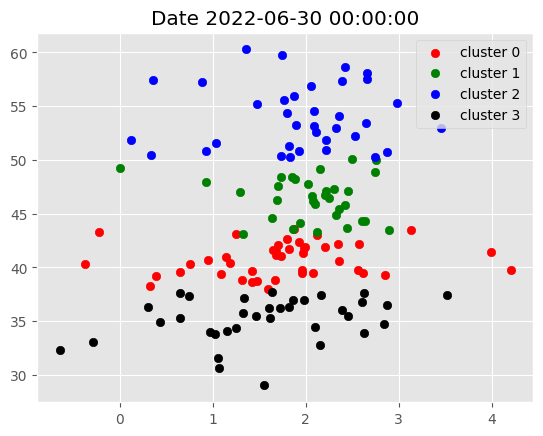

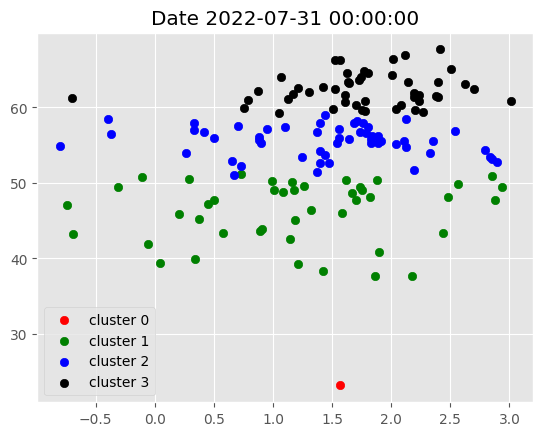

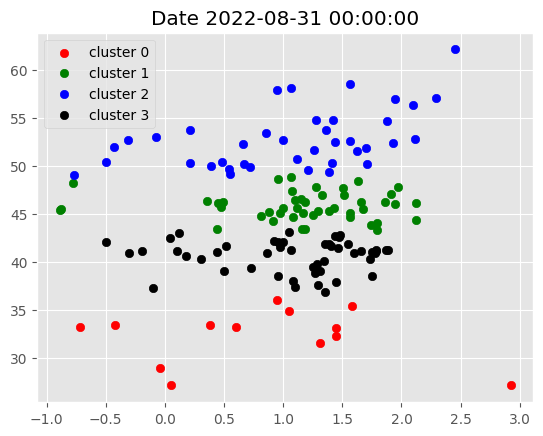

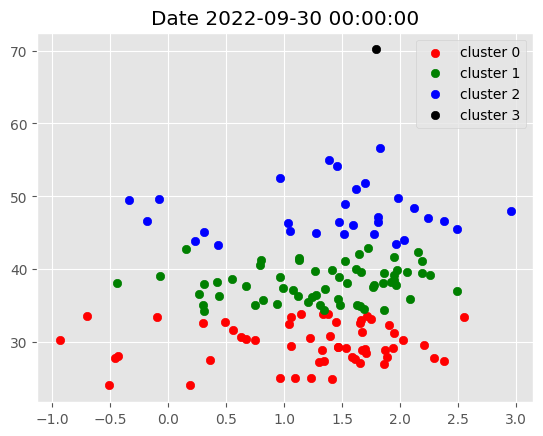

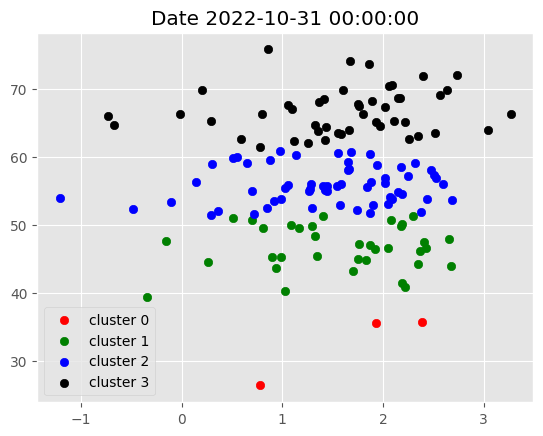

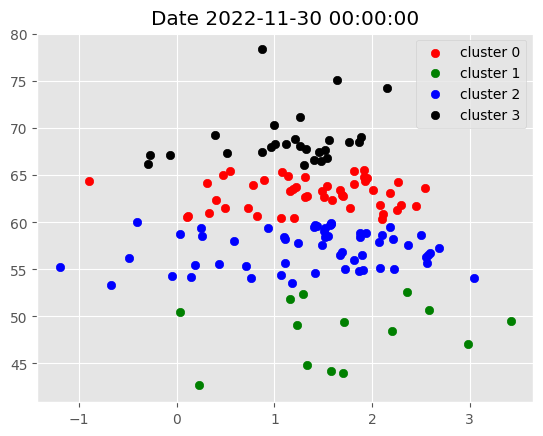

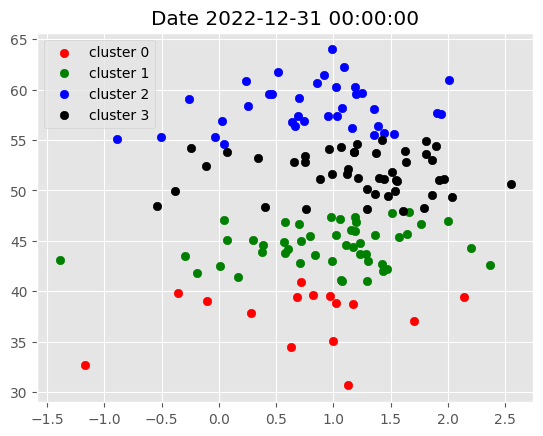

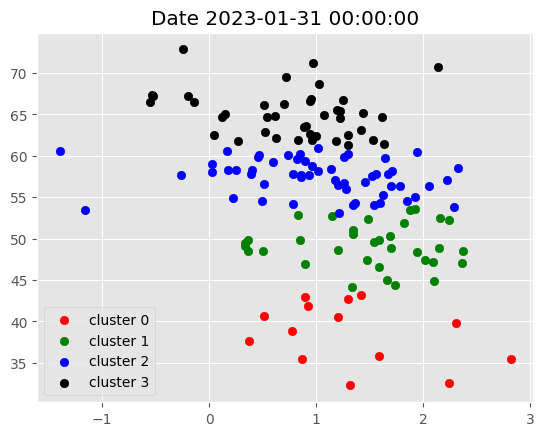

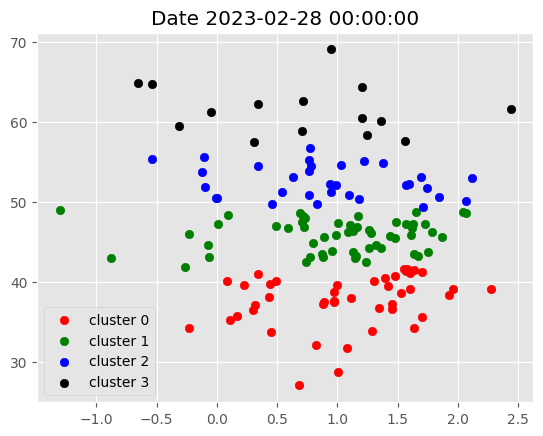

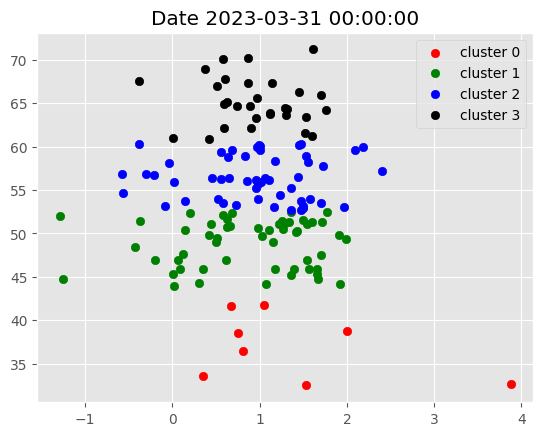

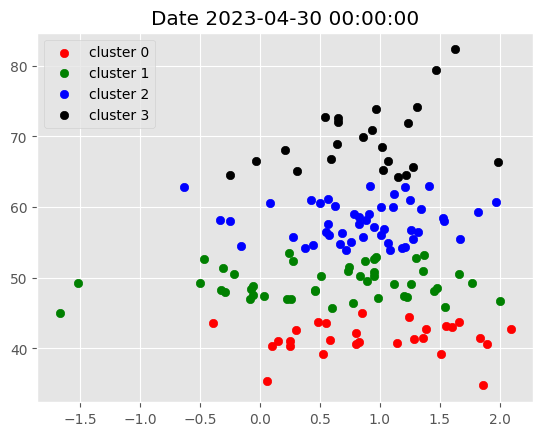

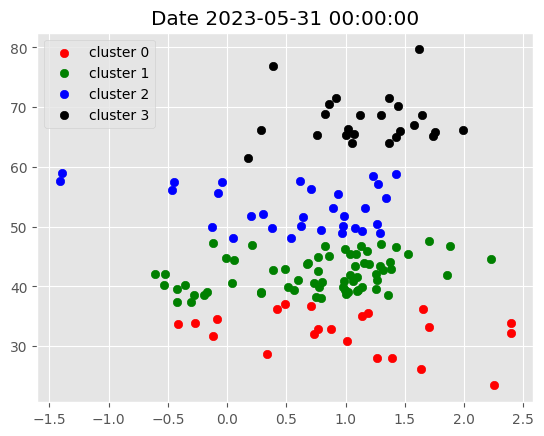

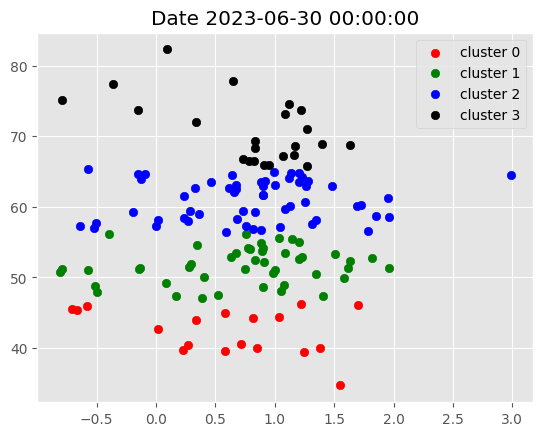

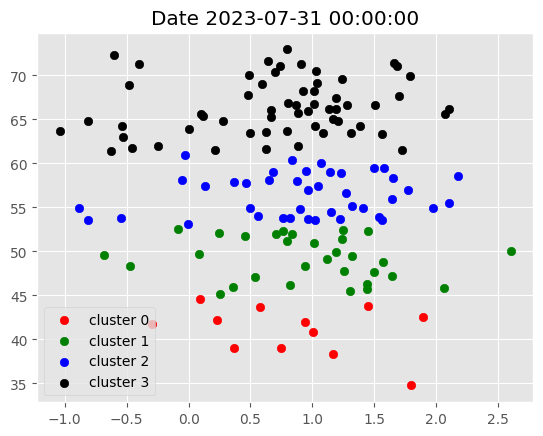

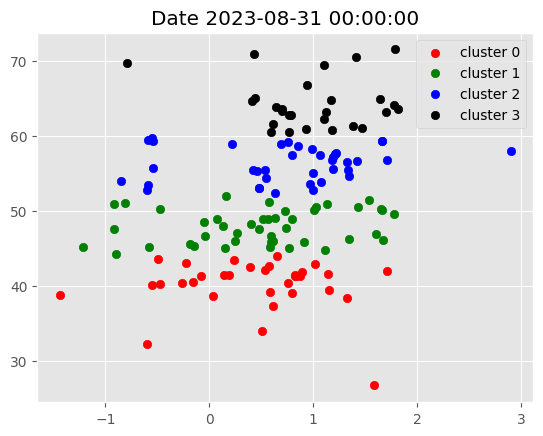

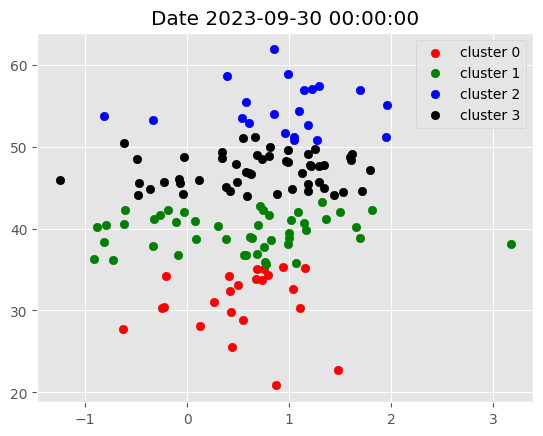

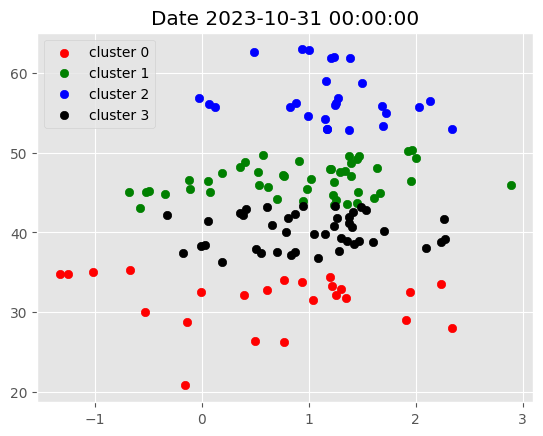

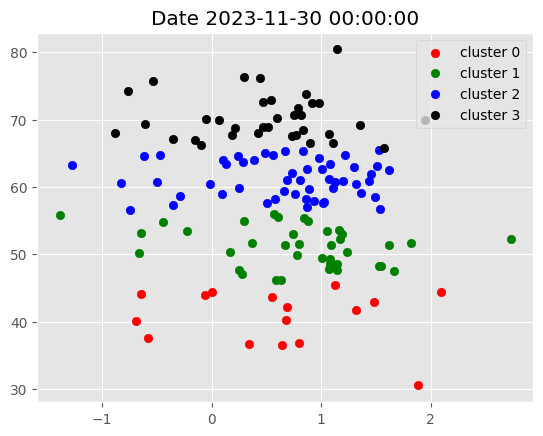

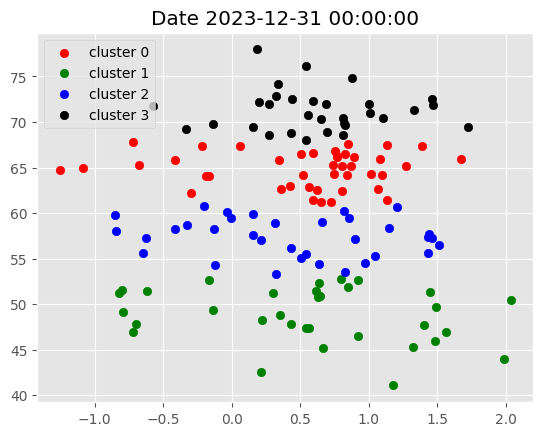

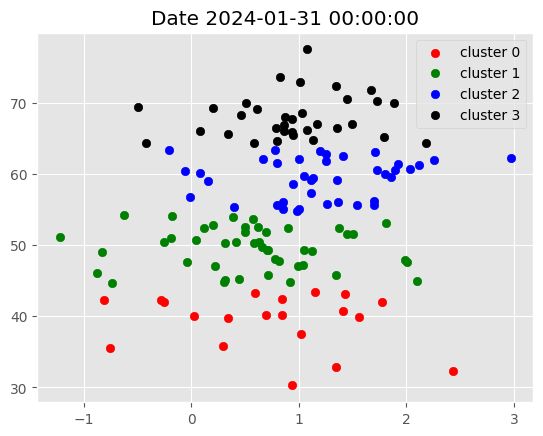

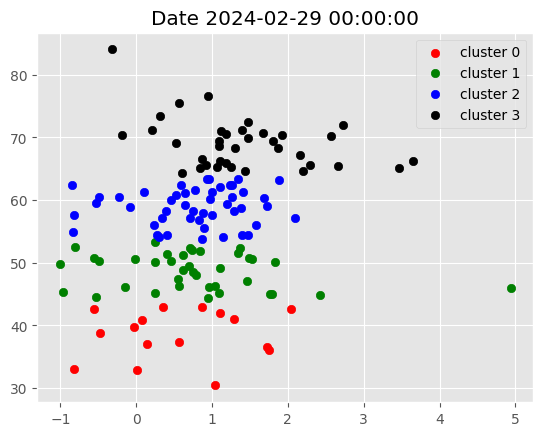

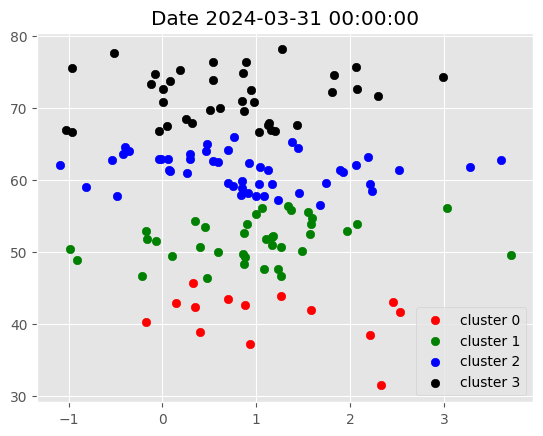

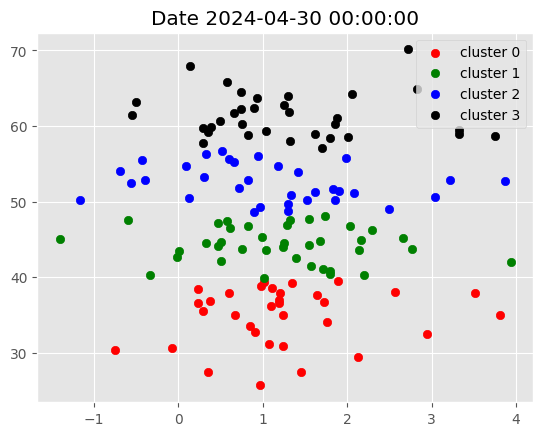

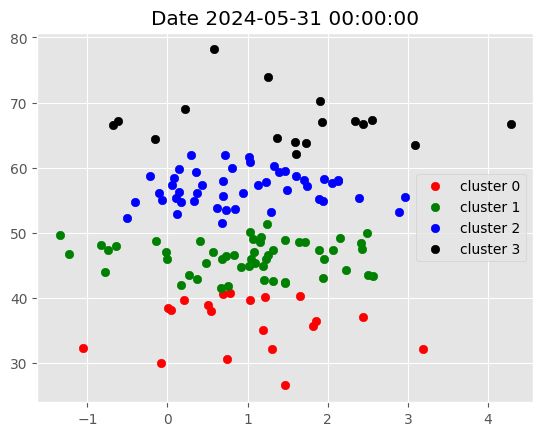

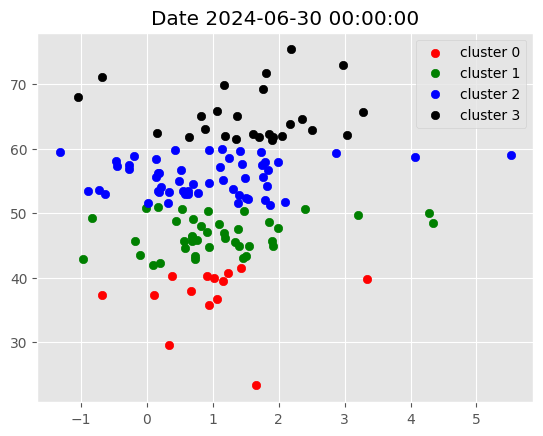

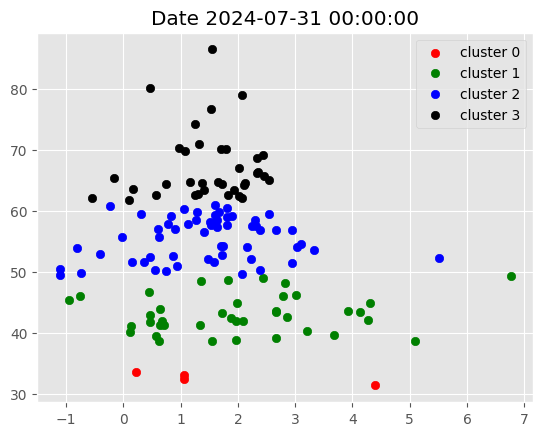

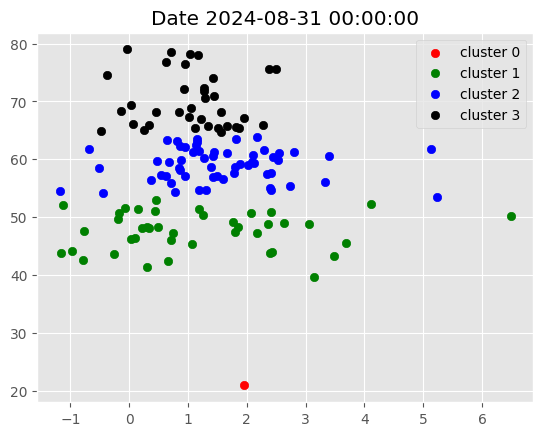

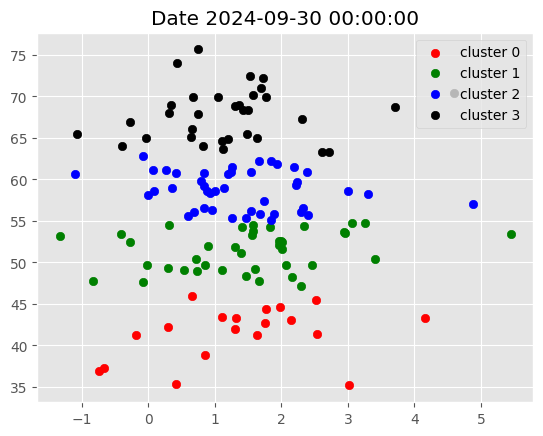

In [31]:
from sklearn.cluster import KMeans

n_epochs = 50
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

for i in range(0,n_epochs):
    data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
    if i<n_epochs-1:
        data = data.drop('cluster', axis=1)

def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [32]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

filtered_df = data[data['cluster']==3].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


# Download fresh stocks data for shortlisted stocks
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

[*********************100%***********************]  198 of 198 completed


In [33]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df['Adj Close'][optimization_start_date:optimization_end_date][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()
portfolio_df = portfolio_df.tz_localize(None, level='date') # remove timezone from under the date
portfolio_df

Max Sharpe Optimization failed for 2011-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2012-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2015-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2015-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2015-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2016-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal-Weights

Strategy Return
date                       
2010-11-01        -0.003577
2010-11-02         0.008525
2010-11-03        -0.002918
2010-11-04         0.010218
2010-11-05         0.004742
...                     ...
2024-09-23         0.004283
2024-09-24        -0.003434
2024-09-25        -0.002095
2024-09-26         0.000034
2024-09-27         0.001105

[3500 rows x 1 columns]

In [34]:
spy = yf.download(tickers='SPY',
                  start='2010-11-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)
portfolio_df['Adjusted Return'] = portfolio_df['Strategy Return'] - portfolio_df['SPY Buy&Hold']
portfolio_df

[*********************100%***********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold  Adjusted Return
2010-11-02         0.008525      0.007899         0.000626
2010-11-03        -0.002918      0.004010        -0.006928
2010-11-04         0.010218      0.019074        -0.008857
2010-11-05         0.004742      0.003756         0.000986
2010-11-08        -0.000846     -0.001876         0.001030
...                     ...           ...              ...
2024-09-23         0.004283      0.002496         0.001788
2024-09-24        -0.003434      0.002857        -0.006291
2024-09-25        -0.002095     -0.002208         0.000113
2024-09-26         0.000034      0.003957        -0.003922
2024-09-27         0.001105     -0.001451         0.002556

[3499 rows x 3 columns]

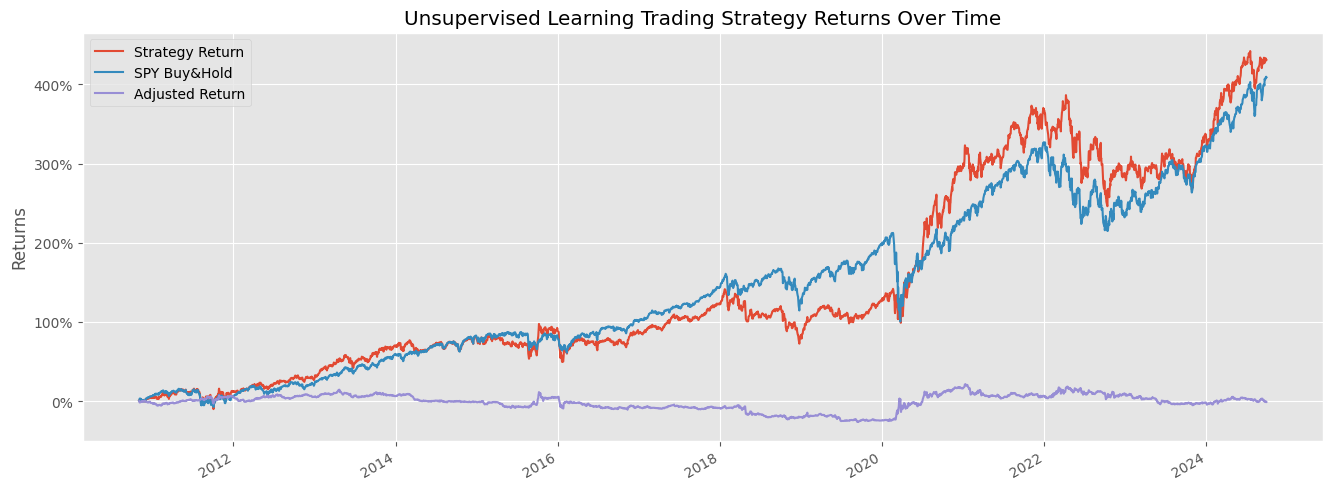

In [35]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:end_date].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Returns')

plt.savefig('returns.jpg')
plt.show()

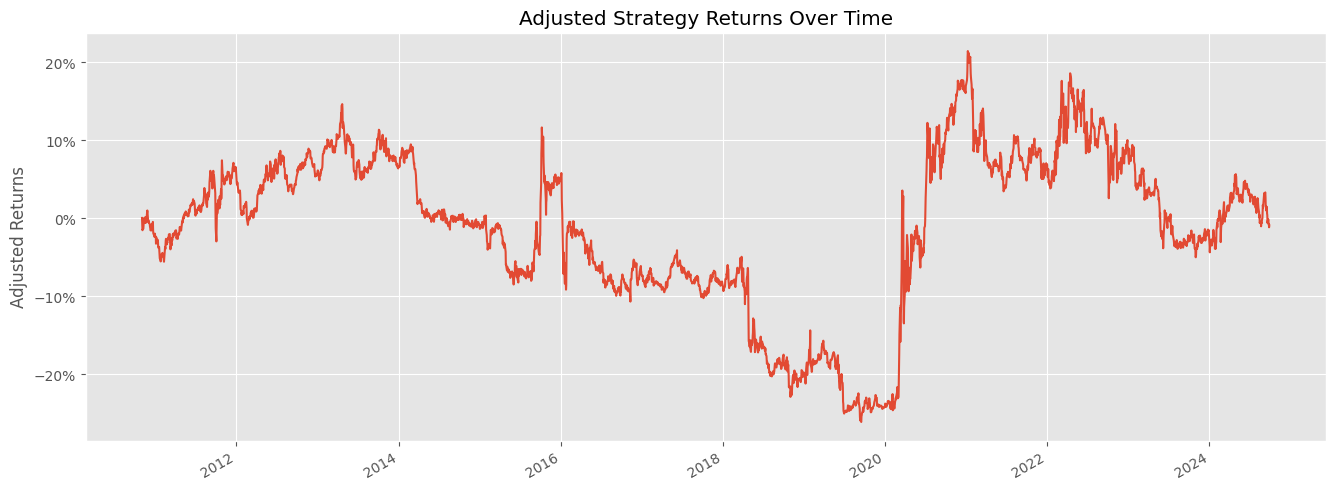

In [37]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df['Adjusted Return']).cumsum())-1

portfolio_cumulative_return[:end_date].plot(figsize=(16,6))

plt.title('Adjusted Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Adjusted Returns')

plt.savefig('adjusted-returns.jpg')
plt.show()